# Start


Importing the necessary libraries


In [1]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.power import TTestIndPower

Loading dataset


In [2]:
file_path: str = "../dataset"
files: tuple[str, ...] = ("connections", "devices", "processes", "profiles")

dataset: dict[str, pd.DataFrame] = {}
for file in files:
    dataset[file] = pd.read_csv(f"{file_path}/{file}.csv", sep="\t")

# 1.1 - Bacis description of data along with their characteristics


## A.)


#### Connections description


In [3]:
dataset["connections"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15108 entries, 0 to 15107
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ts                 15108 non-null  object 
 1   imei               15108 non-null  int64  
 2   mwra               15108 non-null  float64
 3   c.dogalize         15108 non-null  float64
 4   c.android.gm       15108 non-null  float64
 5   c.android.youtube  15108 non-null  float64
 6   c.android.chrome   15108 non-null  float64
 7   c.katana           15108 non-null  float64
 8   c.raider           15108 non-null  float64
 9   c.android.vending  15108 non-null  float64
 10  c.UCMobile.x86     15108 non-null  float64
 11  c.updateassist     15108 non-null  float64
 12  c.UCMobile.intl    15108 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.5+ MB


-   Total Entries: 15,108
-   Total Columns: 13
-   Column Types:
-   11 columns of type float64
-   1 column of type int64
-   1 column of type object
-   There are no missing values in this data


In [4]:
dataset["connections"]["ts"]

0        2018-05-05 10:00:00
1        2018-05-05 10:01:00
2        2018-05-05 10:02:00
3        2018-05-05 10:03:00
4        2018-05-05 10:04:00
                ...         
15103    2018-05-05 20:51:00
15104    2018-05-12 15:15:00
15105    2018-05-08 09:46:00
15106    2018-05-08 20:46:00
15107    2018-05-14 20:56:00
Name: ts, Length: 15108, dtype: object

-   The object column "ts" is date and time


In [5]:
dataset["connections"]["ts"] = pd.to_datetime(dataset["connections"]["ts"])

-   Cast the "ts" column to datetime


In [6]:
connection_summary = dataset["connections"].describe()
median = (
    dataset["connections"].select_dtypes(include=["float64", "int64"]).median()
)  ## adding median to describe method output
connection_summary.loc["median"] = median

## dropping imei, as it has no meaning to make these statistics out of it
connection_summary.drop(columns=["imei"], inplace=True)
connection_summary

ts          mwra    c.dogalize  \
count                           15108  15108.000000  15108.000000   
mean    2018-05-10 14:25:02.581413888      0.625563     10.309496   
min               2018-05-05 10:00:00      0.000000      0.642300   
25%               2018-05-08 00:16:45      0.000000      8.434330   
50%               2018-05-10 14:23:30      1.000000     10.154350   
75%               2018-05-13 04:31:15      1.000000     12.049473   
max               2018-05-15 18:48:00      1.000000     20.212930   
std                               NaN      0.483993      2.626325   
median                            NaN      1.000000     10.154350   

        c.android.gm  c.android.youtube  c.android.chrome      c.katana  \
count   15108.000000       15108.000000      15108.000000  15108.000000   
mean       10.928002          12.141882         10.933567     10.416465   
min         2.587630           2.348110          2.655890      1.165660   
25%         8.943805          10.934585          8.965822      8.538965   
50%        10.844220          12.375635         10.780055     10.263805   
75%        12.850918          13.642702         12.806403     12.192747   
max        22.004980          19.587410         21.092210     19.919510   
std         2.696930           2.225872          2.652465      2.626934   
median     10.844220          12.375635         10.780055     10.263805   

            c.raider  c.android.vending  c.UCMobile.x86  c.updateassist  \
count   15108.000000       15108.000000    15108.000000    15108.000000   
mean       48.846209          49.482347       49.685602       49.822994   
min         0.000000           0.000000        0.000000        0.000000   
25%        39.977420          24.570853       24.731063       24.532995   
50%        48.962015          49.269510       49.300740       49.852925   
75%        57.737270          74.651803       74.873525       75.301215   
max       100.000000         100.000000      100.000000      100.000000   
std        13.031848          28.905578       28.962924       29.030406   
median     48.962015          49.269510       49.300740       49.852925   

        c.UCMobile.intl  
count      15108.000000  
mean          49.805628  
min            0.000000  
25%           24.735187  
50%           49.520235  
75%           74.849797  
max          100.000000  
std           28.843199  
median        49.520235

-   From these tables above we can see imei is a long integer and looks like an ID, if we look at processes table, we can also see same values indicating this could be an Id of device.
-   Another assumption we can make is that columns specifying a connection type (columns starting with c. such as c.android.youtube) have values ranging from 0 to 100, this could indicate that it is a percentage amount of time that the connection was established.


-   First few rows might indicate that the data was sample in a 1 minute interval.
-   Let's look at it closer.


In [7]:
times = dataset["connections"].sort_values(by="ts")["ts"]
times

0       2018-05-05 10:00:00
1       2018-05-05 10:01:00
2       2018-05-05 10:02:00
3       2018-05-05 10:03:00
4       2018-05-05 10:04:00
                ...        
14924   2018-05-15 18:44:00
14925   2018-05-15 18:45:00
14926   2018-05-15 18:46:00
14927   2018-05-15 18:47:00
14928   2018-05-15 18:48:00
Name: ts, Length: 15108, dtype: datetime64[ns]

-   Now we see it looks like samples are in a 1 minute interval.
-   Let's go further.


In [8]:
previous_time: Optional[pd.Series] = None

same_times: int = 0
non_minute_differences: int = 0


for current_time in times:
    if previous_time is None:
        previous_time = current_time
        continue

    if (current_time - previous_time).seconds == 0:
        same_times += 1

    elif (current_time - previous_time).seconds != 60:
        non_minute_differences += 1

    previous_time = current_time

print(f"Non minute differences: {non_minute_differences}")
print(f"Same times: {same_times}")

Non minute differences: 0
Same times: 179


-   From this we can see, that there are data every minute, sometimes more than once at the same time.
-   There are either some duplicates, or data for different devices at the same time.


In [9]:
times = (
    dataset["connections"]
    .groupby(by="imei")[["imei", "ts"]]
    .apply(lambda val: val.sort_values(by="ts", ascending=True))
    .reset_index(drop=True)
)
times

imei                  ts
0       359043379931766007 2018-05-05 11:14:00
1       359043379931766007 2018-05-05 15:58:00
2       359043379931766007 2018-05-05 19:33:00
3       359043379931766007 2018-05-05 19:33:00
4       359043379931766007 2018-05-06 01:55:00
...                    ...                 ...
15103  8630330696303482493 2018-05-14 12:20:00
15104  8630330696303482493 2018-05-14 23:36:00
15105  8630330696303482493 2018-05-14 23:47:00
15106  8630330696303482493 2018-05-15 07:50:00
15107  8630330696303482493 2018-05-15 09:01:00

[15108 rows x 2 columns]

-   If we assume that columns starting with "c." are representing percentage amount of time being active during a time window, we need to group them by device serial number (imei) and then look at the time difference.


In [10]:
dataset["connections"]["mwra"].value_counts()

mwra
1.0    9451
0.0    5657
Name: count, dtype: int64

-   mwra is (Malware-related-activity)
-   In data there are only values 1.0 and 0.0 indicating if there was a malware activity in specific time frame.


#### Devices description


In [11]:
dataset["devices"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    2929 non-null   float64
 1   longitude   2929 non-null   float64
 2   store_name  2929 non-null   object 
 3   code        2929 non-null   object 
 4   location    2929 non-null   object 
 5   imei        2929 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 137.4+ KB


In [12]:
devices_summary = dataset["devices"].describe()
median = (
    dataset["devices"].select_dtypes(include=["float64", "int64"]).median()
)  ## adding median to describe method output
devices_summary.loc["median"] = median

## dropping imei, as it has no meaning to make these statistics out of it
devices_summary.drop(columns=["imei"], inplace=True)
devices_summary

latitude    longitude
count   2929.000000  2929.000000
mean      29.279310    11.548748
std       22.929049    73.811177
min      -54.800000  -156.474320
25%       15.460630   -59.133160
50%       36.192780     9.476290
75%       46.083330    73.000000
max       68.798330   178.004170
median    36.192780     9.476290

In [13]:
dataset["devices"].head()

latitude  longitude         store_name code          location  \
0  48.21644    9.02596           Albstadt   DE     Europe/Berlin   
1  12.74409   -8.07257               Kati   ML     Africa/Bamako   
2   7.83389  -72.47417  Villa del Rosario   CO    America/Bogota   
3  12.37169  123.62494            Masbate   PH       Asia/Manila   
4  39.33427  -76.43941       Middle River   US  America/New_York   

                  imei  
0   863033069630348990  
1  3590433799317661677  
2  3590433799317661990  
3  3590433799317661172  
4   863033069630348073

-   "store_name" object is a string
-   "code" is string, holding code for state
-   "location" is a string, containing continent and city


#### Processes description


In [14]:
dataset["processes"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15108 entries, 0 to 15107
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ts                          15108 non-null  object 
 1   imei                        15108 non-null  int64  
 2   mwra                        15108 non-null  float64
 3   p.android.packageinstaller  15108 non-null  float64
 4   p.android.settings          15108 non-null  float64
 5   p.android.documentsui       15108 non-null  float64
 6   p.android.chrome            15108 non-null  float64
 7   p.android.gm                15108 non-null  float64
 8   p.system                    15108 non-null  float64
 9   p.android.externalstorage   15108 non-null  float64
 10  p.android.vending           15108 non-null  float64
 11  p.process.gapps             15108 non-null  float64
 12  p.google                    15108 non-null  float64
 13  p.browser.provider          151

In [15]:
dataset["processes"]["ts"] = pd.to_datetime(dataset["processes"]["ts"])

In [16]:
processes_summary = dataset["processes"].describe()
median = (
    dataset["processes"].select_dtypes(include=["float64", "int64"]).median()
)  ## adding median to describe method output
processes_summary.loc["median"] = median

## dropping imei, as it has no meaning to make these statistics out of it
processes_summary.drop(columns=["imei"], inplace=True)
processes_summary

ts          mwra  \
count                           15108  15108.000000   
mean    2018-05-10 14:25:02.581413888      0.625563   
min               2018-05-05 10:00:00      0.000000   
25%               2018-05-08 00:16:45      0.000000   
50%               2018-05-10 14:23:30      1.000000   
75%               2018-05-13 04:31:15      1.000000   
max               2018-05-15 18:48:00      1.000000   
std                               NaN      0.483993   
median                            NaN      1.000000   

        p.android.packageinstaller  p.android.settings  p.android.documentsui  \
count                 15108.000000        15108.000000           15108.000000   
mean                     11.572954           11.499864              10.310165   
min                       2.487240            1.570430               2.279980   
25%                       9.739860            9.656940               8.417333   
50%                      11.703395           11.619575              10.138660   
75%                      13.443035           13.414413              12.119515   
max                      20.415500           20.927500              20.122050   
std                       2.636035            2.679572               2.648527   
median                   11.703395           11.619575              10.138660   

        p.android.chrome  p.android.gm      p.system  \
count       15108.000000  15108.000000  15108.000000   
mean            9.790817     12.771425     10.397043   
min             0.000000      5.552490      0.616400   
25%             8.122188     11.547503      8.453595   
50%             9.641190     12.781690     10.351115   
75%            11.364935     14.001280     12.327390   
max            19.855360     19.625710     19.216320   
std             2.436871      1.816167      2.664877   
median          9.641190     12.781690     10.351115   

        p.android.externalstorage  p.android.vending  ...  p.browser.provider  \
count                15108.000000       15108.000000  ...        15108.000000   
mean                    11.576398           0.062140  ...           50.072203   
min                      2.292350           0.000000  ...            0.000000   
25%                      9.704448           0.000240  ...           41.272058   
50%                     11.693555           0.001460  ...           49.965620   
75%                     13.534700           0.010613  ...           58.825585   
max                     21.071240         100.000000  ...          100.000000   
std                      2.713959           1.030622  ...           13.310724   
median                  11.693555           0.001460  ...           49.965620   

        p.android.defcontainer    p.dogalize   p.olauncher   p.simulator  \
count             15108.000000  15108.000000  15108.000000  15108.000000   
mean                 47.326426     50.037140     49.640124     50.022306   
min                   0.000000      0.000000      0.000000      0.000000   
25%                  38.443713     25.007917     24.370213     24.879258   
50%                  47.353845     50.400705     49.551330     50.338015   
75%                  56.251165     75.002775     74.764725     74.949060   
max                 100.000000    100.000000    100.000000    100.000000   
std                  13.104973     28.833214     28.910236     28.957691   
median               47.353845     50.400705     49.551330     50.338015   

        p.inputmethod.latin  p.android.gms    p.notifier      p.katana  \
count          15108.000000   15108.000000  15108.000000  15108.000000   
mean              50.260806      50.272805     49.751673     49.852339   
min                0.000000       0.000000      0.000000      0.000000   
25%               25.193368      25.569652     25.352768     24.522633   
50%               50.040285      50.465125     49.859050     49.514105   
75%               75.316412      75.275442     74.062057     75.035590   
max              100.0

In [17]:
dataset["processes"].head()

ts                 imei  mwra  p.android.packageinstaller  \
0 2018-05-05 10:00:00  3590433799317661693   1.0                     9.23642   
1 2018-05-05 10:01:00   863033069630348362   1.0                    12.12539   
2 2018-05-05 10:02:00   863033069630348040   1.0                    11.93971   
3 2018-05-05 10:03:00  8630330696303482121   0.0                    11.75678   
4 2018-05-05 10:04:00  3590433799317661495   0.0                    13.29218   

   p.android.settings  p.android.documentsui  p.android.chrome  p.android.gm  \
0            14.64737               12.28429           8.10855      11.56273   
1            13.31378                8.53914           8.99158      10.84797   
2            13.62370               13.71940          10.16446      14.61026   
3             5.40945               10.37504          12.96885      15.71257   
4             9.88140               10.48243          12.30196      10.07931   

   p.system  p.android.externalstorage  ...  p.browser.provider  \
0   9.81747                    7.96281  ...            35.91940   
1  10.73896                   12.39776  ...            59.79664   
2  10.14790                   10.00803  ...            37.66953   
3  13.59185                   14.10555  ...            47.54273   
4  14.95220                   12.61291  ...            44.97460   

   p.android.defcontainer  p.dogalize  p.olauncher  p.simulator  \
0                24.95922    21.17604     80.95317     64.67547   
1                48.67044    40.08113     25.00209     86.68513   
2                51.76377    87.50645      8.40823     32.66810   
3                51.31861    40.91248     46.38488     35.03554   
4                35.66277    43.71764     14.70324     73.82801   

   p.inputmethod.latin  p.android.gms  p.notifier  p.katana  p.gms.persistent  
0             55.80378       82.99368    96.45875  95.47350          18.60413  
1              4.17599       65.28470    11.04057  72.81380          55.76611  
2             96.13825        4.88761    29.88836  82.48309          18.89299  
3             24.37016       69.40371    27.45343  53.48129          80.62817  
4             24.01651       55.68464    29.72480  93.90266          79.73910  

[5 rows x 23 columns]

#### Profiles description


In [18]:
dataset["profiles"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2571 entries, 0 to 2570
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   username      2571 non-null   object
 1   address       2185 non-null   object
 2   name          2571 non-null   object
 3   user_id       2571 non-null   int64 
 4   job           771 non-null    object
 5   ssn           2571 non-null   object
 6   company       2571 non-null   object
 7   imei          2571 non-null   int64 
 8   registration  2571 non-null   object
 9   residence     900 non-null    object
 10  mail          2571 non-null   object
 11  birthdate     1414 non-null   object
dtypes: int64(2), object(10)
memory usage: 241.2+ KB


In [19]:
dataset["profiles"]["birthdate"] = pd.to_datetime(dataset["profiles"]["birthdate"])

In [20]:
profiles_summary = dataset["profiles"].describe()
median = (
    dataset["profiles"].select_dtypes(include=["float64", "int64"]).median()
)  ## adding median to describe method output
profiles_summary.loc["median"] = median

## dropping imei, as it has no meaning to make these statistics out of it
profiles_summary.drop(columns=["imei"], inplace=True)
profiles_summary

user_id                      birthdate
count   2571.000000                           1414
mean    1294.560482  1966-02-11 14:38:52.107496464
min        0.000000            1908-11-29 00:00:00
25%      660.500000            1936-12-03 00:00:00
50%     1280.000000            1966-02-25 12:00:00
75%     1938.000000            1996-01-01 06:00:00
max     2570.000000            2024-09-21 00:00:00
std      734.696063                            NaN
median  1280.000000                            NaN

In [21]:
dataset["profiles"].head()

username                                            address  \
0       nancywagner                 Unit 3496 Box 9846\r\nDPO AE 23667   
1      millerdakota    677 Jay Vista Suite 015\r\nBrownhaven, LA 18432   
2      meyerabigail  3746 Baldwin Estate Suite 335\r\nWest Travis, ...   
3       timothyhart  8748 Villarreal Lights\r\nWest Michaelfurt, WA...   
4  jenniferwilliams            499 Michael Flat\r\nJesseview, HI 05817   

                name  user_id                           job          ssn  \
0      Shelly Thomas     1713                           NaN  568-30-2539   
1           Amy Horn     1886                           NaN  395-74-2254   
2      Leah Campbell      184                           NaN  848-91-2310   
3      Joseph Miller      920  Fast food restaurant manager  247-95-0332   
4  Kimberly Williams     2557                           NaN  162-02-9998   

                          company                 imei registration  \
0         Miller, Kirby and Davis   863033069630348636  02 Aug 2018   
1  Gonzalez, Andrade and Robinson   359043379931766007  18 Feb 2022   
2       Boyle, Taylor and Sampson  8630330696303481487   2021/08/17   
3                 Smith-Rodriguez  8630330696303481156   2023-10-24   
4                Ramsey-Fernandez  8630330696303481453   2018-03-19   

                                           residence  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  864 Jared Overpass Suite 869\r\nPort Amanda, W...   
4                                                NaN   

                       mail  birthdate  
0  brandonsmith@hotmail.com 2004-12-08  
1      keithgibbs@gmail.com 1931-09-11  
2         steve72@yahoo.com 1931-11-04  
3     mfletcher@hotmail.com 1955-01-15  
4    ryanmartinez@yahoo.com 1966-09-30

In [22]:
null_values = {file: data.isnull().sum() for file, data in dataset.items()}
for file, nulls in null_values.items():
    if nulls.sum() == 0:
        continue
    print(f"Null values in {file} dataset:")
    print(nulls)
    print("\n")

Null values in profiles dataset:
username           0
address          386
name               0
user_id            0
job             1800
ssn                0
company            0
imei               0
registration       0
residence       1671
mail               0
birthdate       1157
dtype: int64




## B.)


### MWRA


-   First we look at the most important column "mwra" and look at it more in depth.


In [23]:
dataset["connections"]["mwra"].value_counts(normalize=True) * 100

mwra
1.0    62.556262
0.0    37.443738
Name: proportion, dtype: float64

-   In "connections" we can see that positive mwra is ~62%, indicating that there are more positive cases and therefore in future when we put it into our model might falsely evaluate some connections. I would say the closer we are to 50/50 the better.


In [24]:
dataset["processes"]["mwra"].value_counts(normalize=True) * 100

mwra
1.0    62.556262
0.0    37.443738
Name: proportion, dtype: float64

-   "mwra" is the same for "processes" as it is for "connections"


### Connections


#### Defining the variables


In [25]:
chrome_data = dataset["connections"]["c.android.chrome"]
chrome_mean = chrome_data.mean()
chrome_std = chrome_data.std()

dogalize_data = dataset["connections"]["c.dogalize"]
dogalize_mean = dogalize_data.mean()
dogalize_std = dogalize_data.std()

gm_data = dataset["connections"]["c.android.gm"]
gm_mean = gm_data.mean()
gm_std = gm_data.std()

youtube_data = dataset["connections"]["c.android.youtube"]
youtube_mean = youtube_data.mean()
youtube_std = youtube_data.std()

katana_data = dataset["connections"]["c.katana"]
katana_mean = katana_data.mean()
katana_std = katana_data.std()

raider_data = dataset["connections"]["c.raider"]
raider_mean = raider_data.mean()
raider_std = raider_data.std()

vending_data = dataset["connections"]["c.android.vending"]
vending_mean = vending_data.mean()
vending_std = vending_data.std()

x86_data = dataset["connections"]["c.UCMobile.x86"]
x86_mean = x86_data.mean()
x86_std = x86_data.std()


updateassist_data = dataset["connections"]["c.updateassist"]
updateassist_mean = updateassist_data.mean()
updateassist_std = updateassist_data.std()

intl_data = dataset["connections"]["c.UCMobile.intl"]
intl_mean = intl_data.mean()
intl_std = intl_data.std()

all_str_connections: list[str] = [
    "c.android.chrome",
    "c.dogalize",
    "c.android.gm",
    "c.android.youtube",
    "c.katana",
    "c.raider",
    "c.android.vending",
    "c.UCMobile.x86",
    "c.updateassist",
    "c.UCMobile.intl",
]

all_data_connections: list[pd.Series] = [
    chrome_data,
    dogalize_data,
    gm_data,
    youtube_data,
    katana_data,
    raider_data,
    vending_data,
    x86_data,
    updateassist_data,
    intl_data,
]

all_means_connections: list[float] = [
    chrome_mean,
    dogalize_mean,
    gm_mean,
    youtube_mean,
    katana_mean,
    raider_mean,
    vending_mean,
    x86_mean,
    updateassist_mean,
    intl_mean,
]

all_std_connections: list[float] = [
    chrome_std,
    dogalize_std,
    gm_std,
    youtube_std,
    katana_std,
    raider_std,
    vending_std,
    x86_std,
    updateassist_std,
    intl_std,
]

#### Measure of dispersion


In [26]:
df = dataset["connections"].iloc[:, 3:].describe()
df.loc["full_range"] = df.loc["max"] - df.loc["min"]
df.loc["interquartile_range"] = df.loc["75%"] - df.loc["25%"]
df

c.dogalize  c.android.gm  c.android.youtube  \
count                15108.000000  15108.000000       15108.000000   
mean                    10.309496     10.928002          12.141882   
std                      2.626325      2.696930           2.225872   
min                      0.642300      2.587630           2.348110   
25%                      8.434330      8.943805          10.934585   
50%                     10.154350     10.844220          12.375635   
75%                     12.049473     12.850918          13.642702   
max                     20.212930     22.004980          19.587410   
full_range              19.570630     19.417350          17.239300   
interquartile_range      3.615143      3.907113           2.708117   

                     c.android.chrome      c.katana      c.raider  \
count                    15108.000000  15108.000000  15108.000000   
mean                        10.933567     10.416465     48.846209   
std                          2.652465      2.626934     13.031848   
min                          2.655890      1.165660      0.000000   
25%                          8.965822      8.538965     39.977420   
50%                         10.780055     10.263805     48.962015   
75%                         12.806403     12.192747     57.737270   
max                         21.092210     19.919510    100.000000   
full_range                  18.436320     18.753850    100.000000   
interquartile_range          3.840580      3.653783     17.759850   

                     c.android.vending  c.UCMobile.x86  c.updateassist  \
count                     15108.000000    15108.000000    15108.000000   
mean                         49.482347       49.685602       49.822994   
std                          28.905578       28.962924       29.030406   
min                           0.000000        0.000000        0.000000   
25%                          24.570853       24.731063       24.532995   
50%                          49.269510       49.300740       49.852925   
75%                          74.651803       74.873525       75.301215   
max                         100.000000      100.000000      100.000000   
full_range                  100.000000      100.000000      100.000000   
interquartile_range          50.080950       50.142463       50.768220   

                     c.UCMobile.intl  
count                   15108.000000  
mean                       49.805628  
std                        28.843199  
min                         0.000000  
25%                        24.735187  
50%                        49.520235  
75%                        74.849797  
max                       100.000000  
full_range                100.000000  
interquartile_range        50.114610

#### Measure of center


In [27]:
apps = all_str_connections

means = all_means_connections

medians = [
    chrome_data.median(),
    dogalize_data.median(),
    gm_data.median(),
    youtube_data.median(),
    katana_data.median(),
    raider_data.median(),
    vending_data.median(),
    x86_data.median(),
    updateassist_data.median(),
    intl_data.median(),
]

max_values = []
most_occurring_values = []

value_counts = chrome_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = dogalize_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = gm_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = youtube_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = katana_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = raider_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = vending_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = x86_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = updateassist_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())

value_counts = intl_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())

for i in range(len(most_occurring_values)):
    most_occurring_values[i] = most_occurring_values[i][: min(3, len(most_occurring_values[i]))]


data = {
    "connection": apps,
    "mean": means,
    "median": medians,
    "mode_count": max_values,
    "mode_values": most_occurring_values,
}

df = pd.DataFrame(data)
df

connection       mean     median  mode_count  \
0   c.android.chrome  10.933567  10.780055           3   
1         c.dogalize  10.309496  10.154350           3   
2       c.android.gm  10.928002  10.844220           3   
3  c.android.youtube  12.141882  12.375635           3   
4           c.katana  10.416465  10.263805           3   
5           c.raider  48.846209  48.962015           3   
6  c.android.vending  49.482347  49.269510           2   
7     c.UCMobile.x86  49.685602  49.300740           2   
8     c.updateassist  49.822994  49.852925           2   
9    c.UCMobile.intl  49.805628  49.520235           2   

                      mode_values  
0  [15.09277, 13.96247, 12.66087]  
1     [8.4362, 8.08643, 10.34456]  
2     [7.37316, 9.99788, 9.46395]  
3  [14.20878, 13.29313, 12.68658]  
4  [11.87016, 13.43679, 11.03079]  
5            [60.99804, 48.39264]  
6  [38.08731, 34.79229, 32.50178]  
7   [47.83628, 76.1005, 37.45813]  
8   [65.22365, 55.65401, 66.5042]  
9   [69.34231, 40.47904, 3.54383]

#### Measure of shape


In [28]:
def skewness_type(skew_value: float) -> str:
    if skew_value <= -1:
        return "Highly Negative Skew"

    elif skew_value <= -0.5:
        return "Moderately Negative Skew"

    elif skew_value <= 0.5:
        return "Approximately Symmetric"

    elif skew_value <= 1:
        return "Moderately Positive Skew"

    return "Highly Positive Skew"

In [29]:
def kurtosis_type(kurtosis_value: float) -> str:
    if kurtosis_value < -1:
        return "Negative Kurtosis"

    elif kurtosis_value < -0.5:
        return "Moderately Negative Kurtosis"

    elif kurtosis_value < 0.5:
        return "Approximately Normal Kurtosis"

    elif kurtosis_value < 1:
        return "Moderately Positive Kurtosis"

    return "Positive Kurtosis"

In [30]:
data = {
    "connection": all_str_connections,
    "skew": [
        stats.skew(chrome_data),
        stats.skew(dogalize_data),
        stats.skew(gm_data),
        stats.skew(youtube_data),
        stats.skew(katana_data),
        stats.skew(raider_data),
        stats.skew(vending_data),
        stats.skew(x86_data),
        stats.skew(updateassist_data),
        stats.skew(intl_data),
    ],
    "kurtosis": [
        stats.kurtosis(chrome_data),
        stats.kurtosis(dogalize_data),
        stats.kurtosis(gm_data),
        stats.kurtosis(youtube_data),
        stats.kurtosis(katana_data),
        stats.kurtosis(raider_data),
        stats.kurtosis(vending_data),
        stats.kurtosis(x86_data),
        stats.kurtosis(updateassist_data),
        stats.kurtosis(intl_data),
    ],
}

shape_df = pd.DataFrame(data)

shape_df["result skew"] = shape_df["skew"].apply(skewness_type)
shape_df["result kurtosis"] = shape_df["kurtosis"].apply(kurtosis_type)
shape_df.set_index("connection", inplace=True)
shape_df

skew  kurtosis               result skew  \
connection                                                        
c.android.chrome   0.202709 -0.402562   Approximately Symmetric   
c.dogalize         0.238739 -0.157746   Approximately Symmetric   
c.android.gm       0.145092 -0.284452   Approximately Symmetric   
c.android.youtube -0.617624  0.687939  Moderately Negative Skew   
c.katana           0.210126 -0.189410   Approximately Symmetric   
c.raider          -0.023362 -0.059577   Approximately Symmetric   
c.android.vending  0.015750 -1.198576   Approximately Symmetric   
c.UCMobile.x86     0.014363 -1.211366   Approximately Symmetric   
c.updateassist     0.008036 -1.221742   Approximately Symmetric   
c.UCMobile.intl    0.005795 -1.204259   Approximately Symmetric   

                                 result kurtosis  
connection                                        
c.android.chrome   Approximately Normal Kurtosis  
c.dogalize         Approximately Normal Kurtosis  
c.android.gm       Approximately Normal Kurtosis  
c.android.youtube   Moderately Positive Kurtosis  
c.katana           Approximately Normal Kurtosis  
c.raider           Approximately Normal Kurtosis  
c.android.vending              Negative Kurtosis  
c.UCMobile.x86                 Negative Kurtosis  
c.updateassist                 Negative Kurtosis  
c.UCMobile.intl                Negative Kurtosis

#### Histograms with KDE


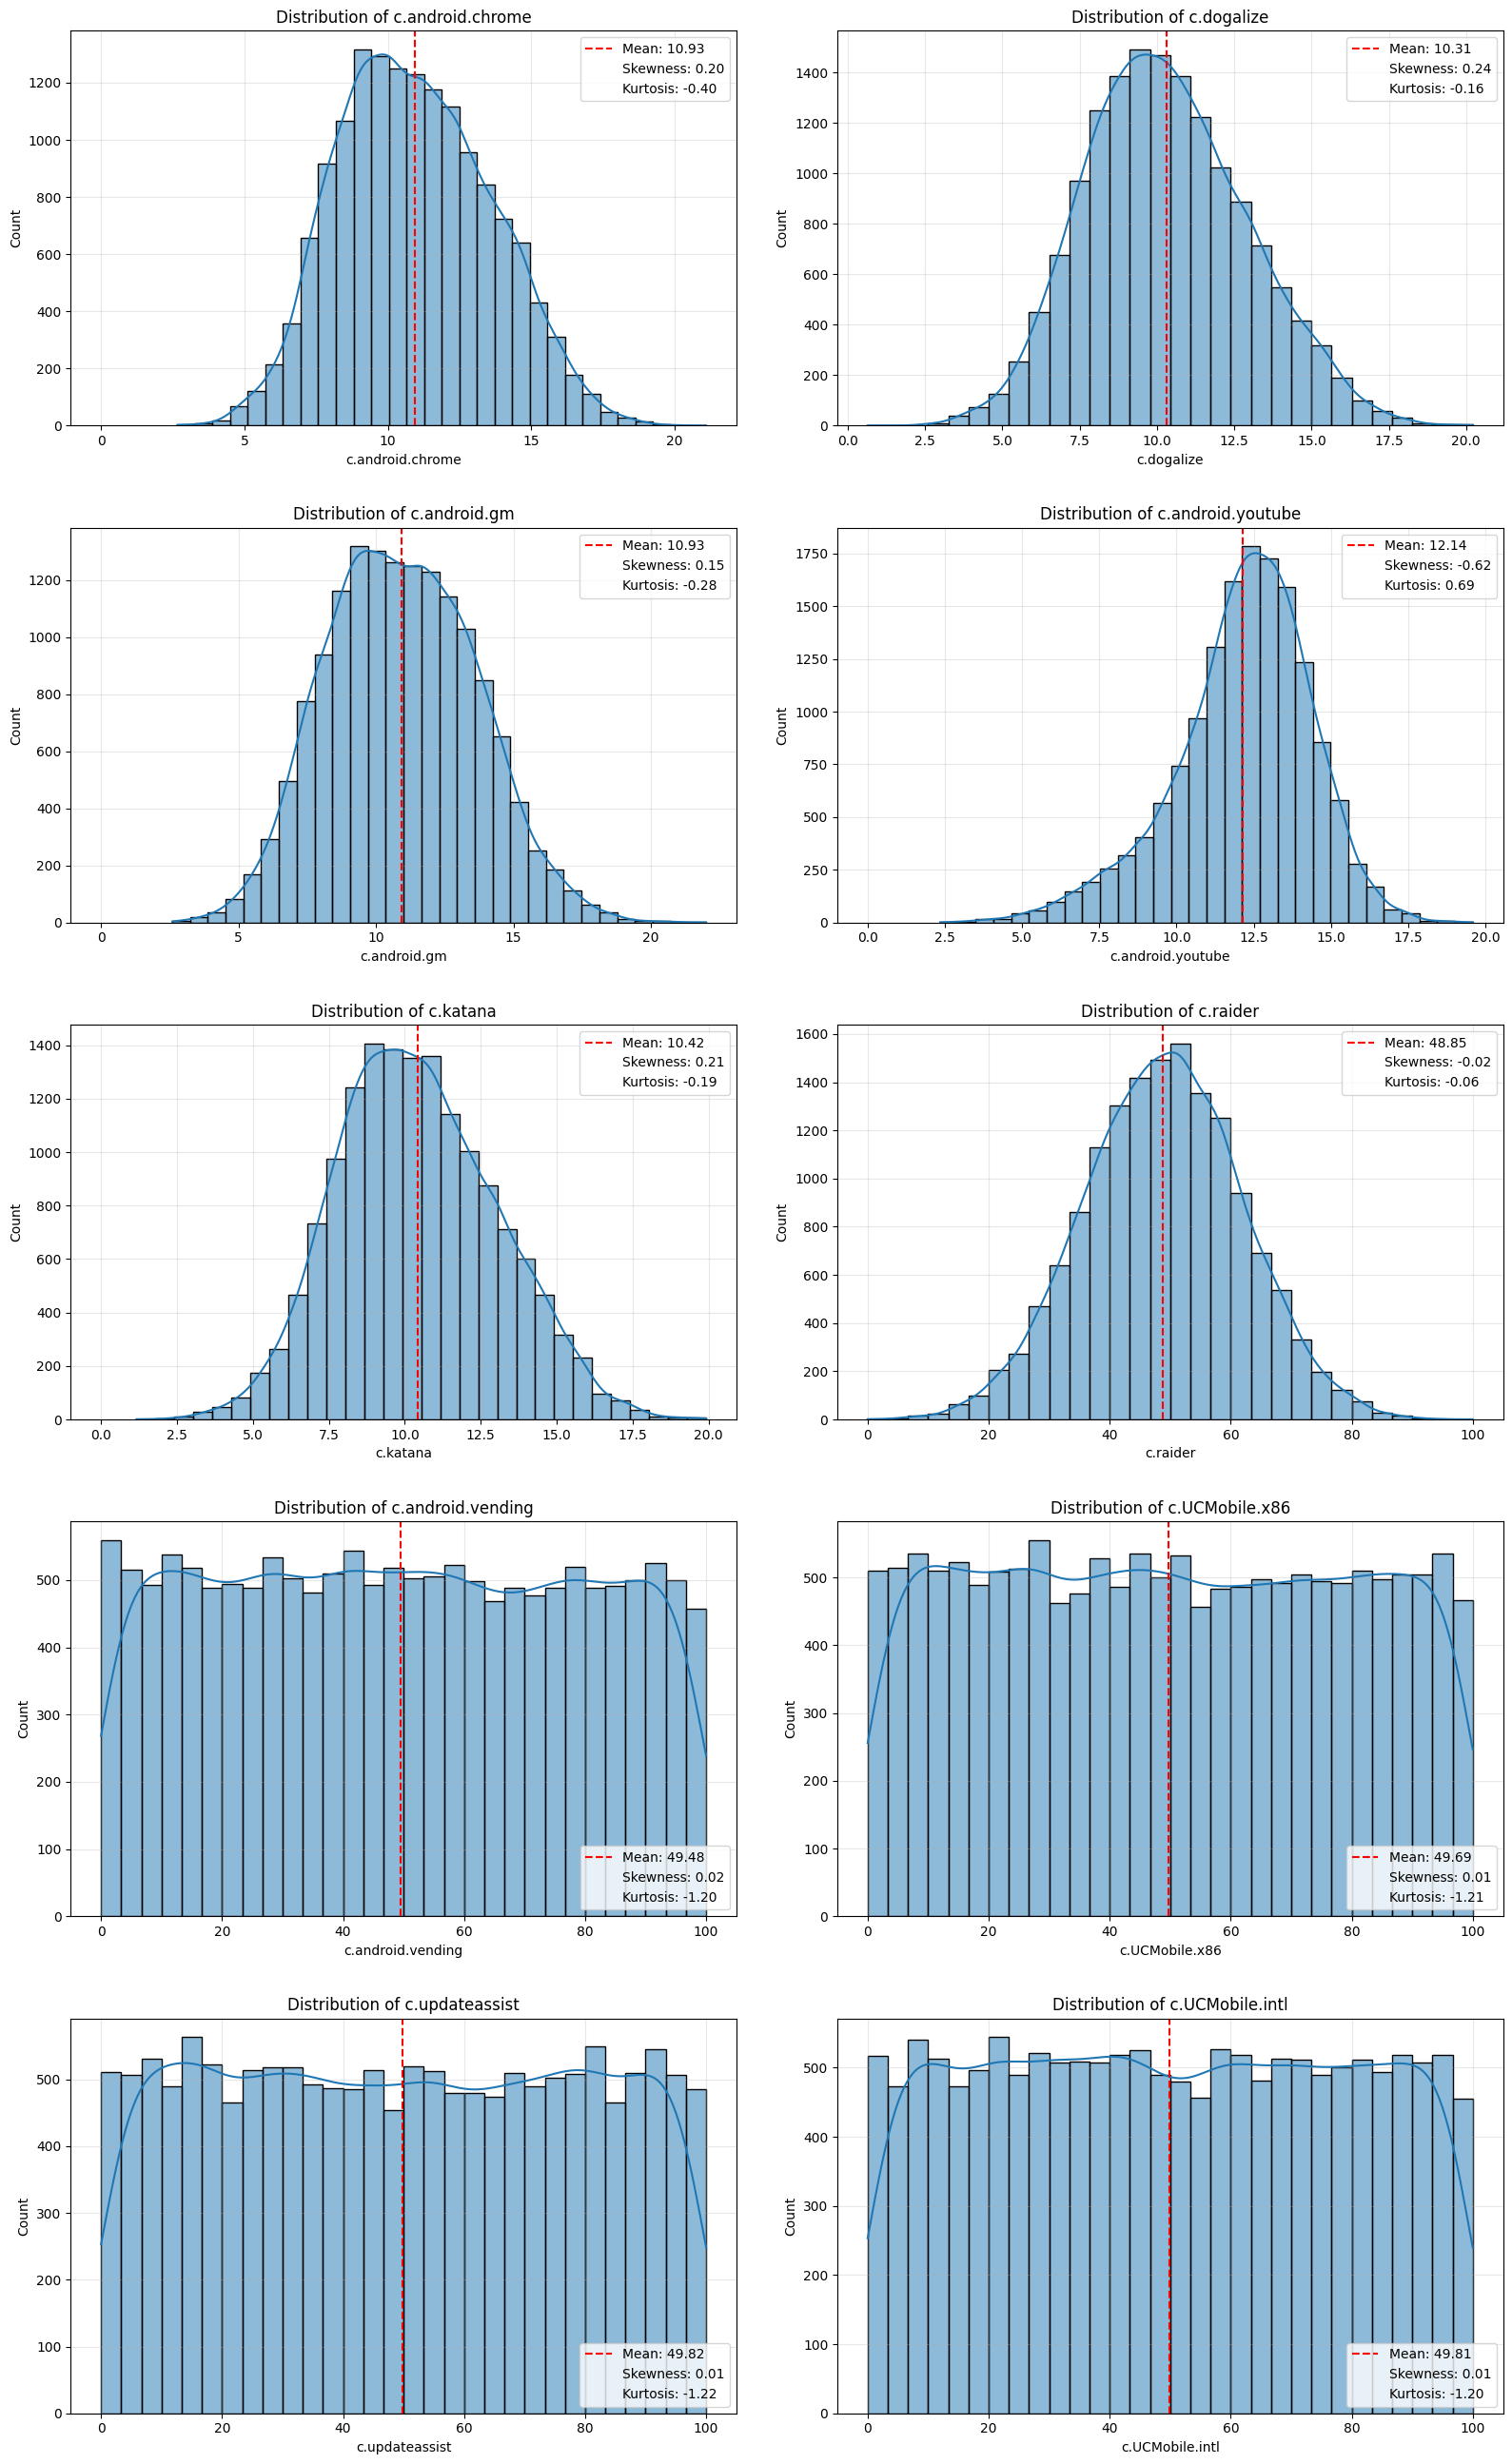

In [31]:
_, axes = plt.subplots(5, 2, figsize=(16, 26))


## Having all the data in a list, we can iterate over it and plot the histogram with KDE for each connection.
for i in range(len(all_data_connections)):
    sns.histplot(all_data_connections[i], bins=30, kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].axvline(
        all_means_connections[i], color="r", linestyle="--", label=f"Mean: {all_means_connections[i]:.2f}"
    )
    axes[i // 2, i % 2].axvline(
        linestyle="", label=f"Skewness: {shape_df.loc[all_str_connections[i]]['skew']:.2f}"
    )
    axes[i // 2, i % 2].axvline(
        linestyle="", label=f"Kurtosis: {shape_df.loc[all_str_connections[i]]['kurtosis']:.2f}"
    )
    axes[i // 2, i % 2].set_title(f"Distribution of {all_str_connections[i]}")
    axes[i // 2, i % 2].legend()
    axes[i // 2, i % 2].grid(True, alpha=0.3)

## Adjust the layout
plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

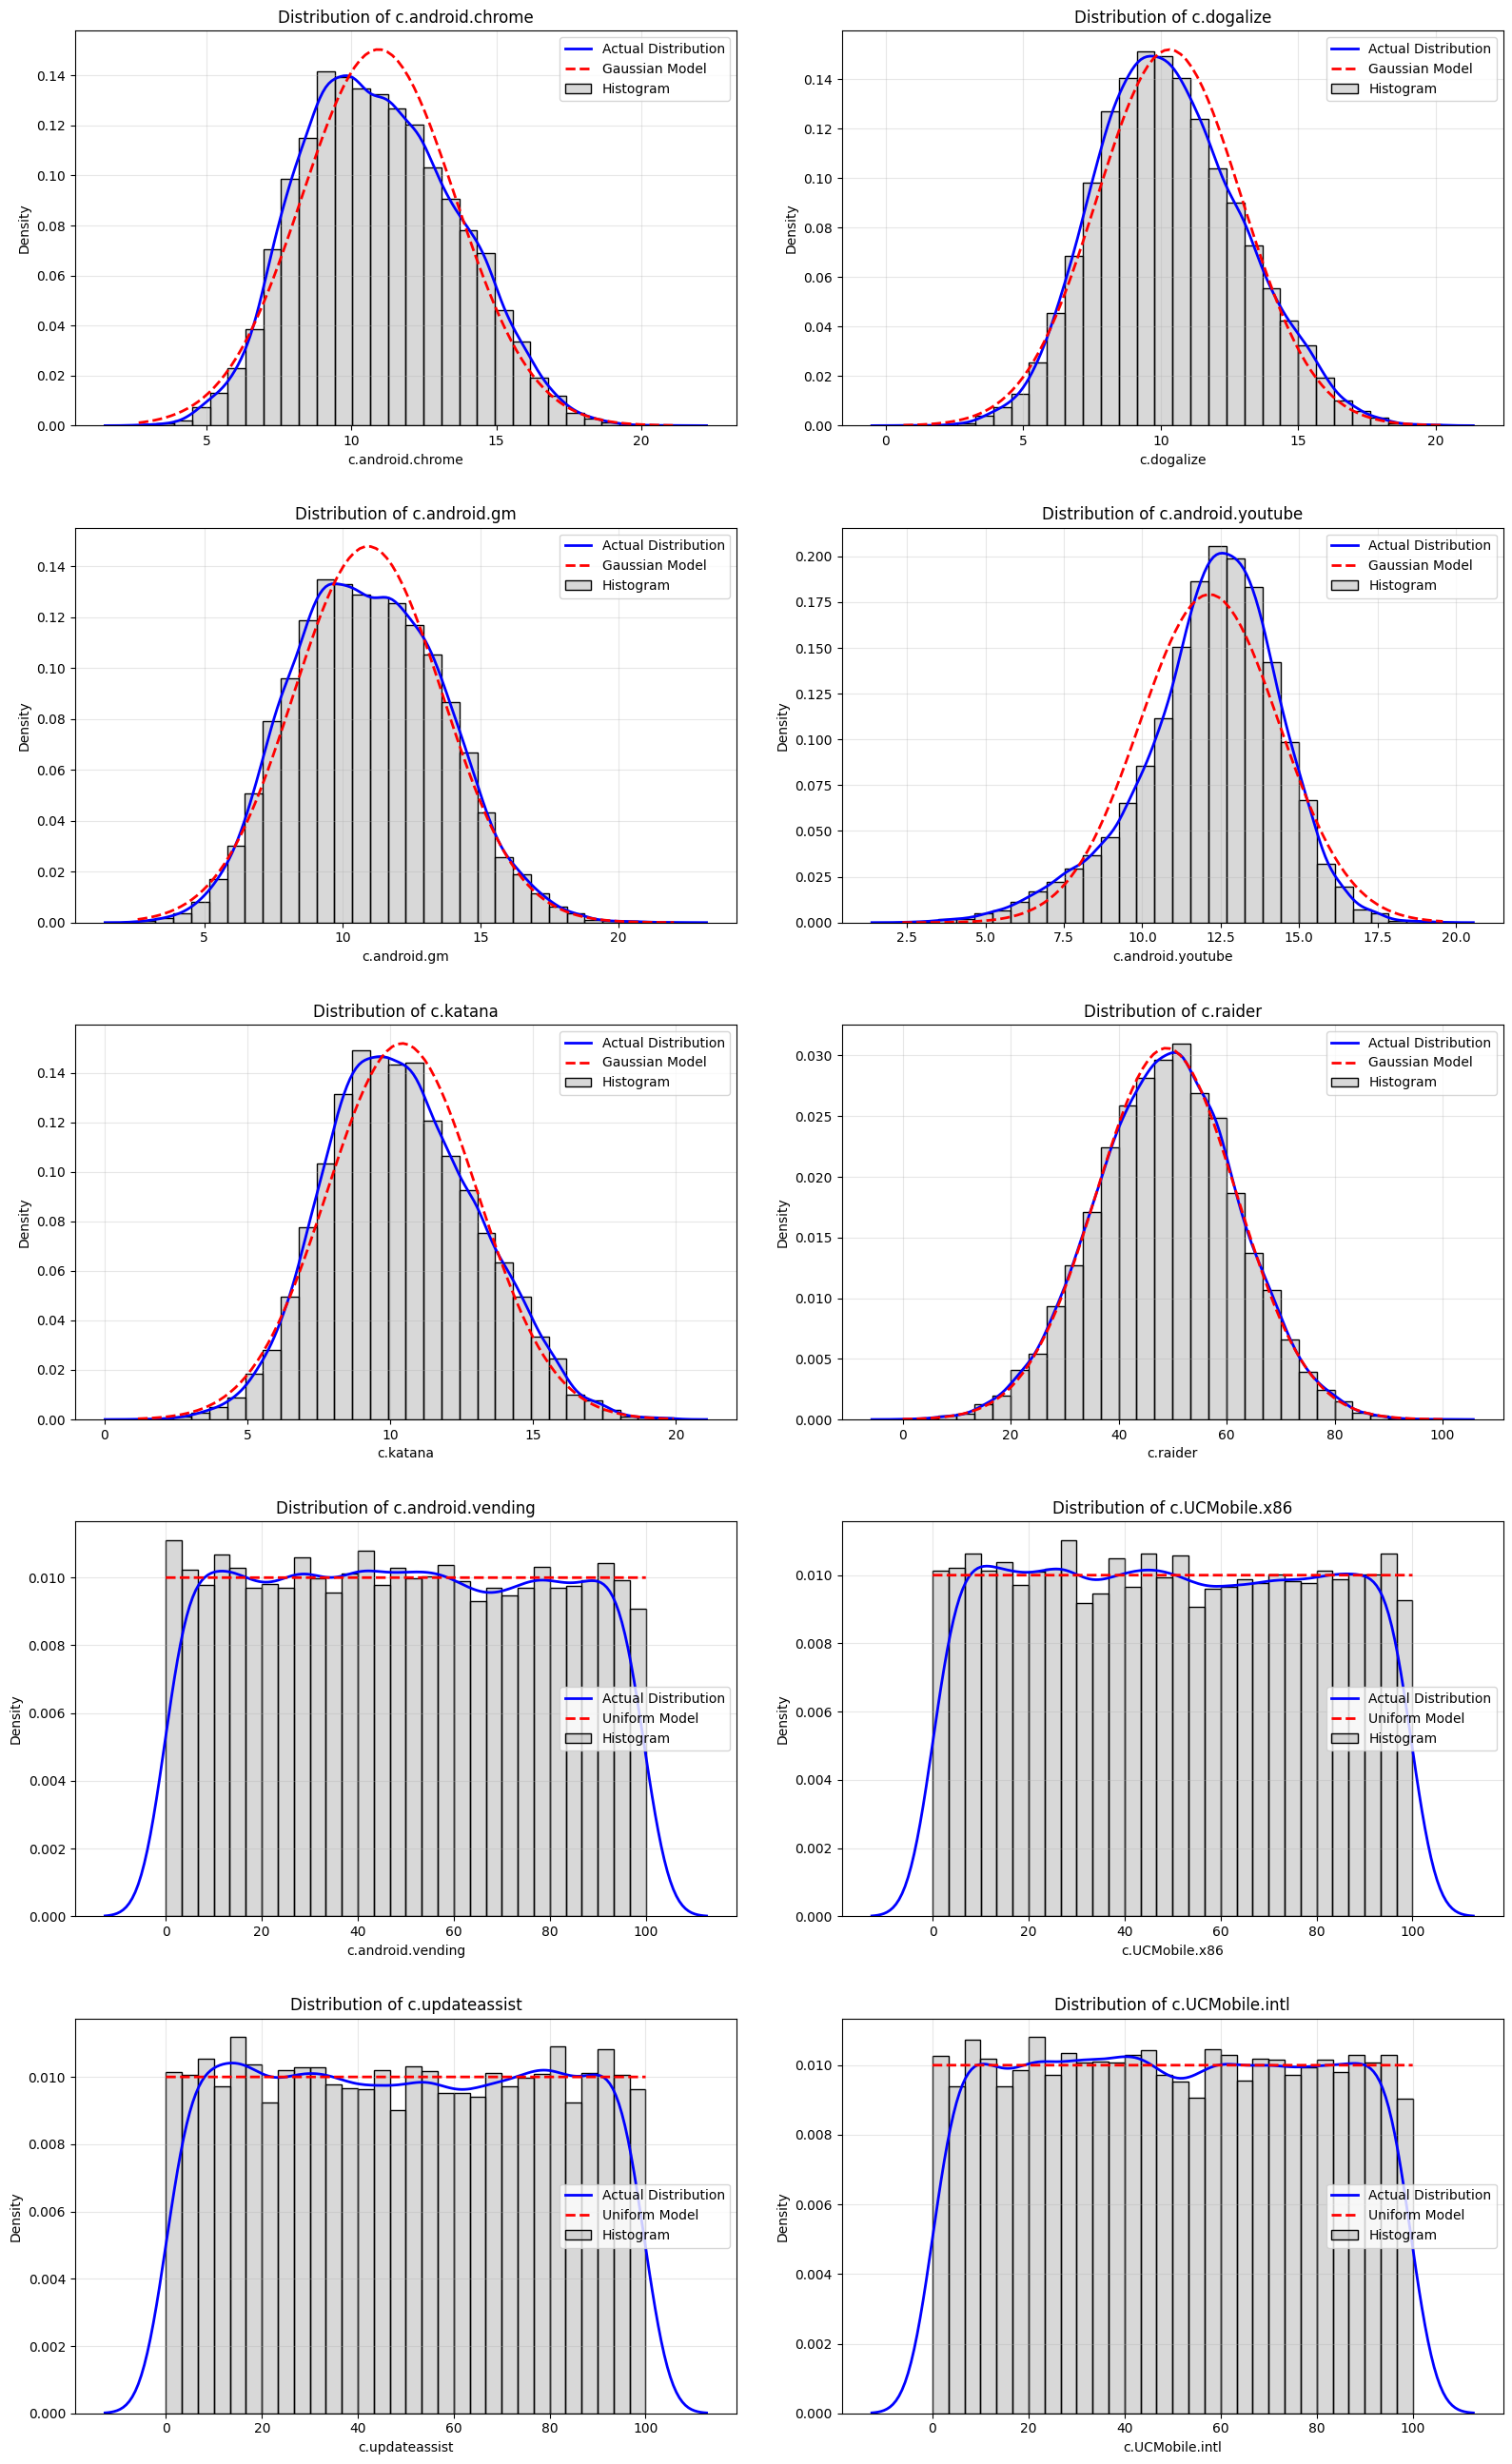

In [32]:
_, axes = plt.subplots(5, 2, figsize=(16, 26))

for i in range(len(all_data_connections)):
    sns.histplot(
        data=all_data_connections[i],
        bins=30,
        stat="density",
        alpha=0.3,
        color="gray",
        label="Histogram",
        ax=axes[i // 2, i % 2],
    )
    sns.kdeplot(
        data=all_data_connections[i],
        color="blue",
        label="Actual Distribution",
        linewidth=2,
        ax=axes[i // 2, i % 2],
    )

    if i <= 5:  ## We know that first 6 connections are not uniform
        x = np.linspace(all_data_connections[i].min(), all_data_connections[i].max(), 100)
        gaussian = stats.norm.pdf(x, all_means_connections[i], all_std_connections[i])
        axes[i // 2, i % 2].plot(
            x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2
        )

    else:
        a = all_data_connections[i].min()
        b = all_data_connections[i].max()
        x = np.linspace(a, b, all_data_connections[i].size)
        uniform_dist = stats.uniform(loc=a, scale=b - a)
        axes[i // 2, i % 2].plot(
            x, uniform_dist.pdf(x), color="red", linestyle="--", label="Uniform Model", linewidth=2
        )

    axes[i // 2, i % 2].set_title(f"Distribution of {all_str_connections[i]}")
    axes[i // 2, i % 2].legend()
    axes[i // 2, i % 2].grid(True, alpha=0.3)


## Adjust the layout
plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

#### Boxplots


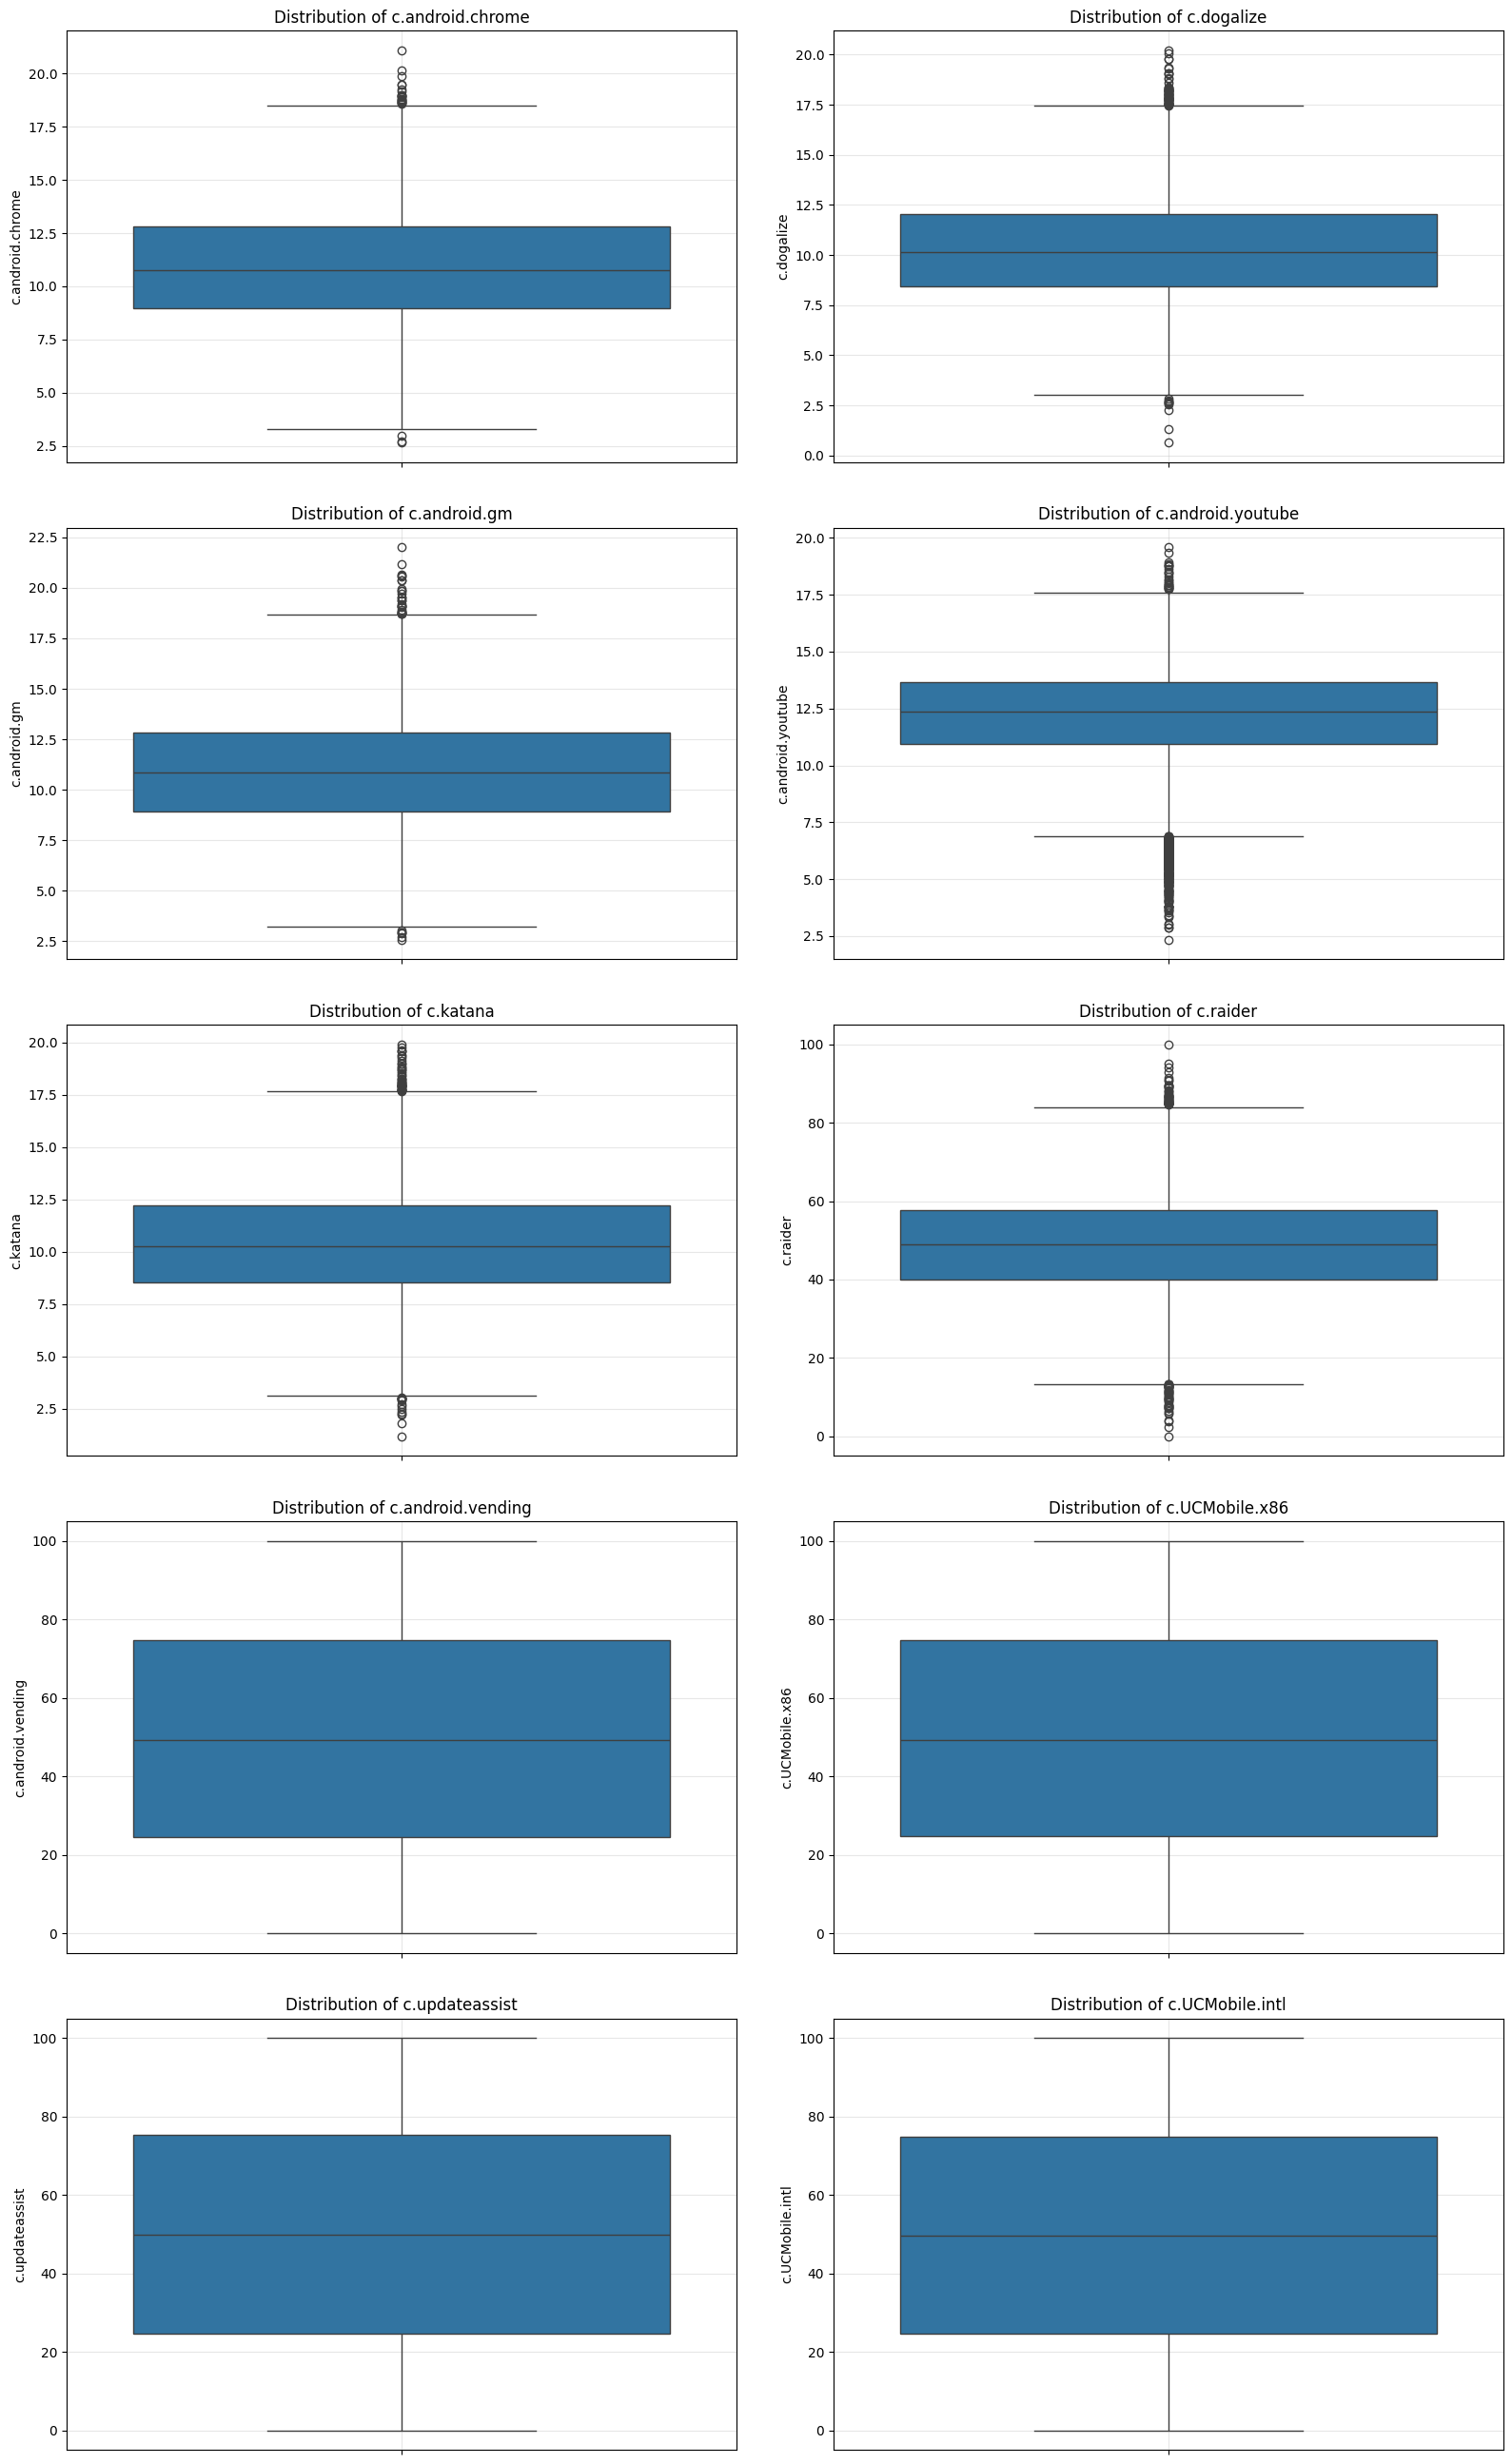

In [33]:
_, axes = plt.subplots(5, 2, figsize=(16, 26))

for i in range(len(all_data_connections)):
    sns.boxplot(all_data_connections[i], ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"Distribution of {all_str_connections[i]}")
    axes[i // 2, i % 2].grid(True, alpha=0.3)

## Adjust the layout
plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

#### Q-Q plots


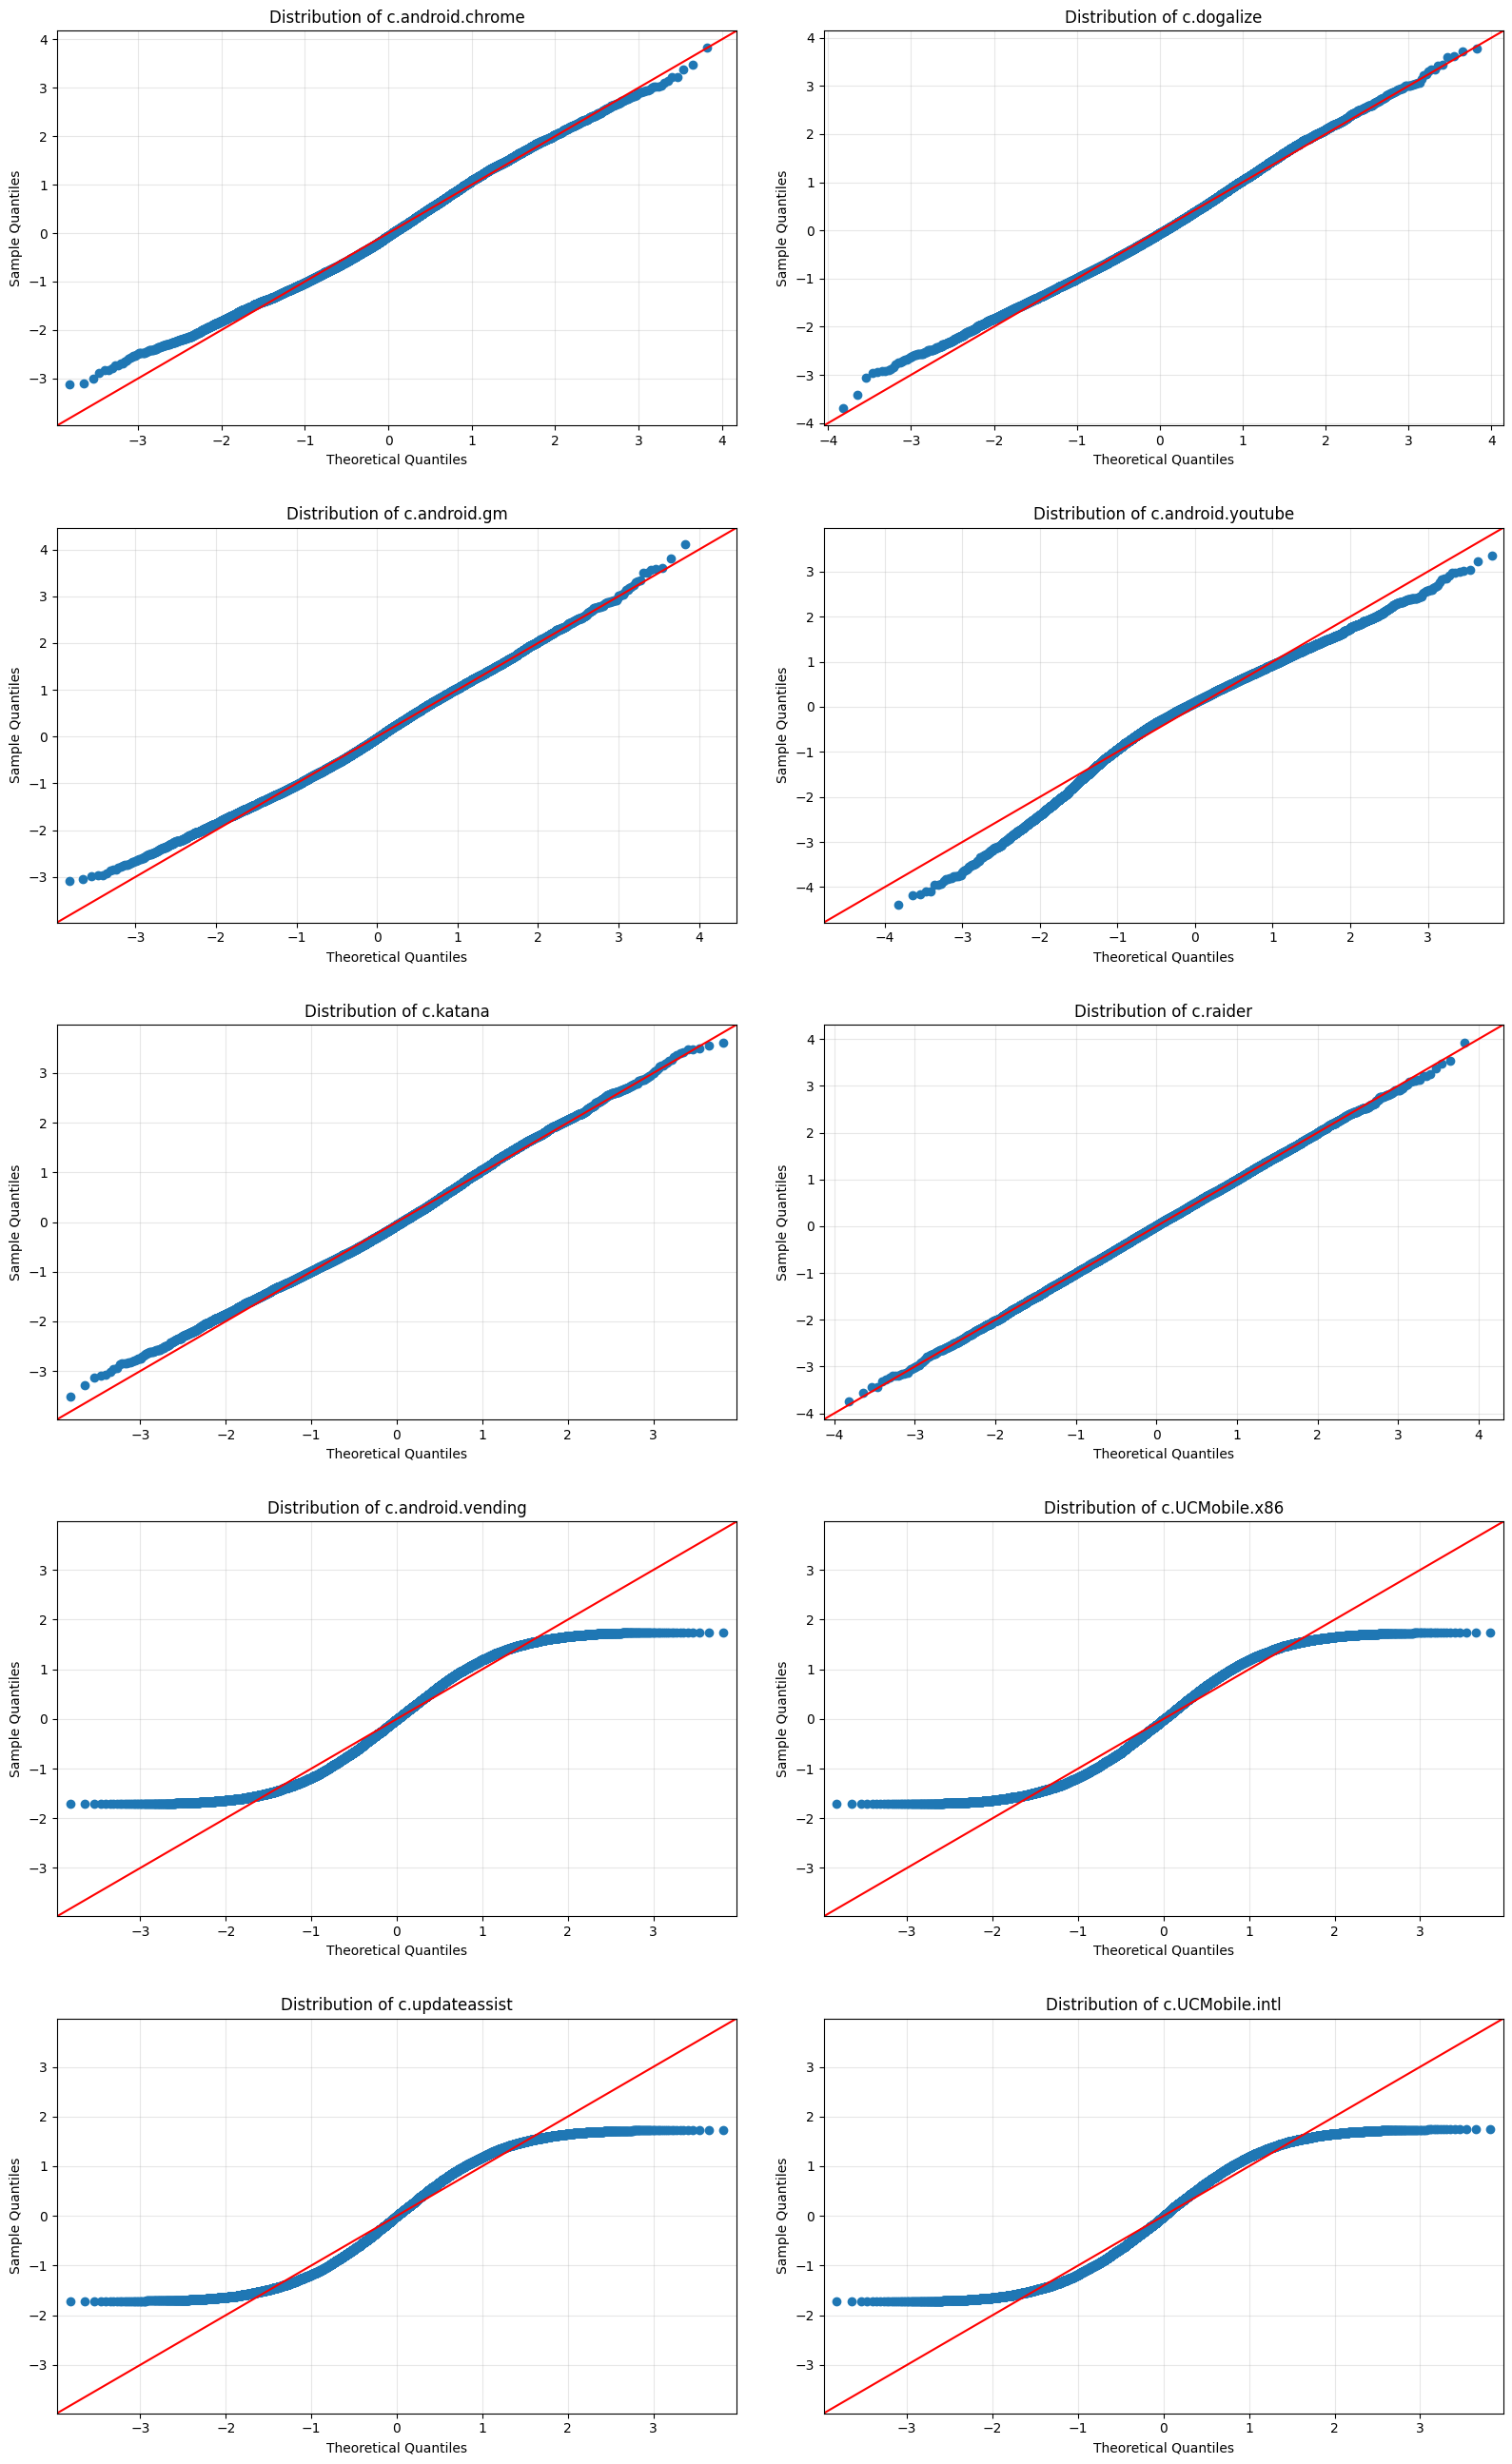

In [34]:
_, axes = plt.subplots(5, 2, figsize=(16, 26))

for i in range(len(all_data_connections)):
    sm.qqplot(all_data_connections[i], fit=True, line="45", ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"Distribution of {all_str_connections[i]}")
    axes[i // 2, i % 2].grid(True, alpha=0.3)

## Adjust the layout
plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

### Processes


#### Defining the variables


In [35]:
chrome_data = dataset["processes"]["p.android.chrome"]
chrome_mean = chrome_data.mean()
chrome_std = chrome_data.std()

dogalize_data = dataset["processes"]["p.dogalize"]
dogalize_mean = dogalize_data.mean()
dogalize_std = dogalize_data.std()

katana_data = dataset["processes"]["p.katana"]
katana_mean = katana_data.mean()
katana_std = katana_data.std()

settings_data = dataset["processes"]["p.android.settings"]
settings_mean = settings_data.mean()
settings_std = settings_data.std()

system_data = dataset["processes"]["p.system"]
system_mean = system_data.mean()
system_std = system_data.std()

simulator_data = dataset["processes"]["p.simulator"]
simulator_mean = simulator_data.mean()
simulator_std = simulator_data.std()

all_str_processes: list[str] = [
    "p.android.chrome",
    "p.dogalize",
    "p.katana",
    "p.android.settings",
    "p.system",
    "p.simulator",
]

all_data_processes: list[pd.Series] = [
    chrome_data,
    dogalize_data,
    katana_data,
    settings_data,
    system_data,
    simulator_data,
]

all_means_processes: list[float] = [
    chrome_mean,
    dogalize_mean,
    katana_mean,
    settings_mean,
    system_mean,
    simulator_mean,
]

all_std_processes: list[float] = [
    chrome_std,
    dogalize_std,
    katana_std,
    settings_std,
    system_std,
    simulator_std,
]

#### Measure of dispersion


In [36]:
df = dataset["processes"][all_str_processes].describe()
df.loc["full_range"] = df.loc["max"] - df.loc["min"]
df.loc["interquartile_range"] = df.loc["75%"] - df.loc["25%"]
df

p.android.chrome    p.dogalize      p.katana  \
count                    15108.000000  15108.000000  15108.000000   
mean                         9.790817     50.037140     49.852339   
std                          2.436871     28.833214     28.967083   
min                          0.000000      0.000000      0.000000   
25%                          8.122188     25.007917     24.522633   
50%                          9.641190     50.400705     49.514105   
75%                         11.364935     75.002775     75.035590   
max                         19.855360    100.000000    100.000000   
full_range                  19.855360    100.000000    100.000000   
interquartile_range          3.242747     49.994858     50.512957   

                     p.android.settings      p.system   p.simulator  
count                      15108.000000  15108.000000  15108.000000  
mean                          11.499864     10.397043     50.022306  
std                            2.679572      2.664877     28.957691  
min                            1.570430      0.616400      0.000000  
25%                            9.656940      8.453595     24.879258  
50%                           11.619575     10.351115     50.338015  
75%                           13.414413     12.327390     74.949060  
max                           20.927500     19.216320    100.000000  
full_range                    19.357070     18.599920    100.000000  
interquartile_range            3.757473      3.873795     50.069803

#### Measure of center


In [37]:
apps = all_str_processes

means = all_means_processes

medians = [
    chrome_data.median(),
    dogalize_data.median(),
    katana_data.median(),
    settings_data.median(),
    system_data.median(),
    simulator_data.median(),
]

max_values = []
most_occurring_values = []

value_counts = chrome_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = dogalize_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = katana_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = settings_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = system_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())


value_counts = simulator_data.value_counts()
max_val = value_counts.max()
max_values.append(max_val)
most_occurring_values.append(value_counts[value_counts == max_val].index.tolist())

for i in range(len(most_occurring_values)):
    most_occurring_values[i] = most_occurring_values[i][: min(3, len(most_occurring_values[i]))]


data = {
    "process": apps,
    "mean": means,
    "median": medians,
    "mode_count": max_values,
    "mode_values": most_occurring_values,
}

df = pd.DataFrame(data)
df

process       mean     median  mode_count  \
0    p.android.chrome   9.790817   9.641190           3   
1          p.dogalize  50.037140  50.400705           3   
2            p.katana  49.852339  49.514105           2   
3  p.android.settings  11.499864  11.619575           3   
4            p.system  10.397043  10.351115           3   
5         p.simulator  50.022306  50.338015           3   

                     mode_values  
0    [9.25661, 9.09418, 9.60399]  
1                     [95.18917]  
2  [24.32851, 76.86749, 76.0943]  
3                     [10.65882]  
4                     [11.54941]  
5                     [72.82827]

#### Measure of shape


In [38]:
data = {
    "process": all_str_processes,
    "skew": [
        stats.skew(chrome_data),
        stats.skew(dogalize_data),
        stats.skew(katana_data),
        stats.skew(settings_data),
        stats.skew(system_data),
        stats.skew(simulator_data),
    ],
    "kurtosis": [
        stats.kurtosis(chrome_data),
        stats.kurtosis(dogalize_data),
        stats.kurtosis(katana_data),
        stats.kurtosis(settings_data),
        stats.kurtosis(system_data),
        stats.kurtosis(simulator_data),
    ],
}

shape_df = pd.DataFrame(data)
shape_df["result skew"] = shape_df["skew"].apply(skewness_type)
shape_df["result kurtosis"] = shape_df["kurtosis"].apply(kurtosis_type)
shape_df.set_index("process", inplace=True)
shape_df

skew  kurtosis              result skew  \
process                                                           
p.android.chrome    0.221976  0.040229  Approximately Symmetric   
p.dogalize         -0.015236 -1.198147  Approximately Symmetric   
p.katana            0.006712 -1.212223  Approximately Symmetric   
p.android.settings -0.160093 -0.224145  Approximately Symmetric   
p.system            0.016187 -0.377024  Approximately Symmetric   
p.simulator        -0.001083 -1.205955  Approximately Symmetric   

                                  result kurtosis  
process                                            
p.android.chrome    Approximately Normal Kurtosis  
p.dogalize                      Negative Kurtosis  
p.katana                        Negative Kurtosis  
p.android.settings  Approximately Normal Kurtosis  
p.system            Approximately Normal Kurtosis  
p.simulator                     Negative Kurtosis

#### Histograms with KDE


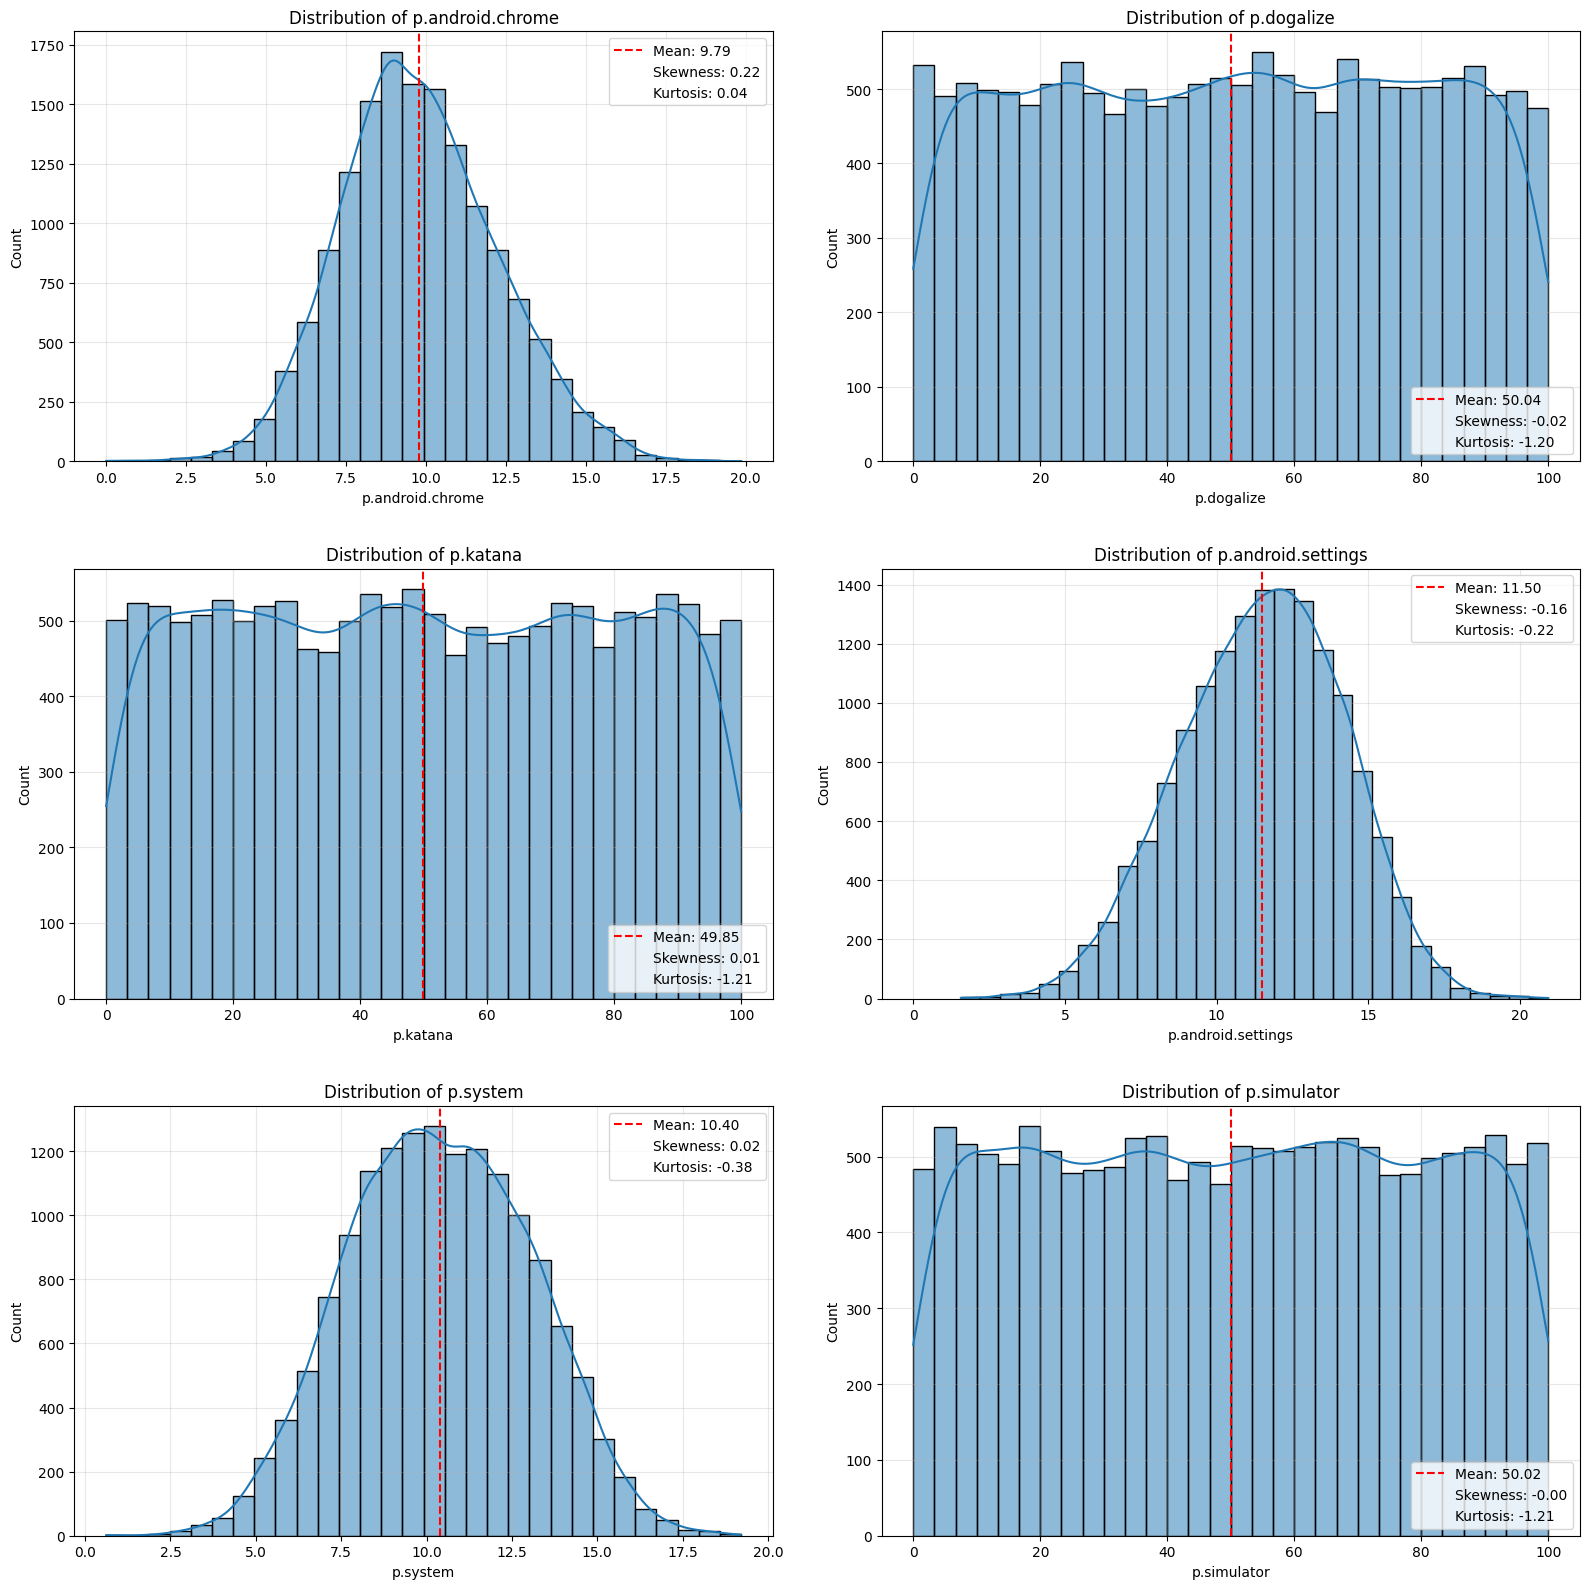

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

for i in range(len(all_data_processes)):
    sns.histplot(all_data_processes[i], bins=30, kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].axvline(
        all_means_processes[i], color="r", linestyle="--", label=f"Mean: {all_means_processes[i]:.2f}"
    )
    axes[i // 2, i % 2].axvline(
        linestyle="", label=f"Skewness: {shape_df.loc[all_str_processes[i]]['skew']:.2f}"
    )
    axes[i // 2, i % 2].axvline(
        linestyle="", label=f"Kurtosis: {shape_df.loc[all_str_processes[i]]['kurtosis']:.2f}"
    )
    axes[i // 2, i % 2].set_title(f"Distribution of {all_str_processes[i]}")
    axes[i // 2, i % 2].legend()
    axes[i // 2, i % 2].grid(True, alpha=0.3)

plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

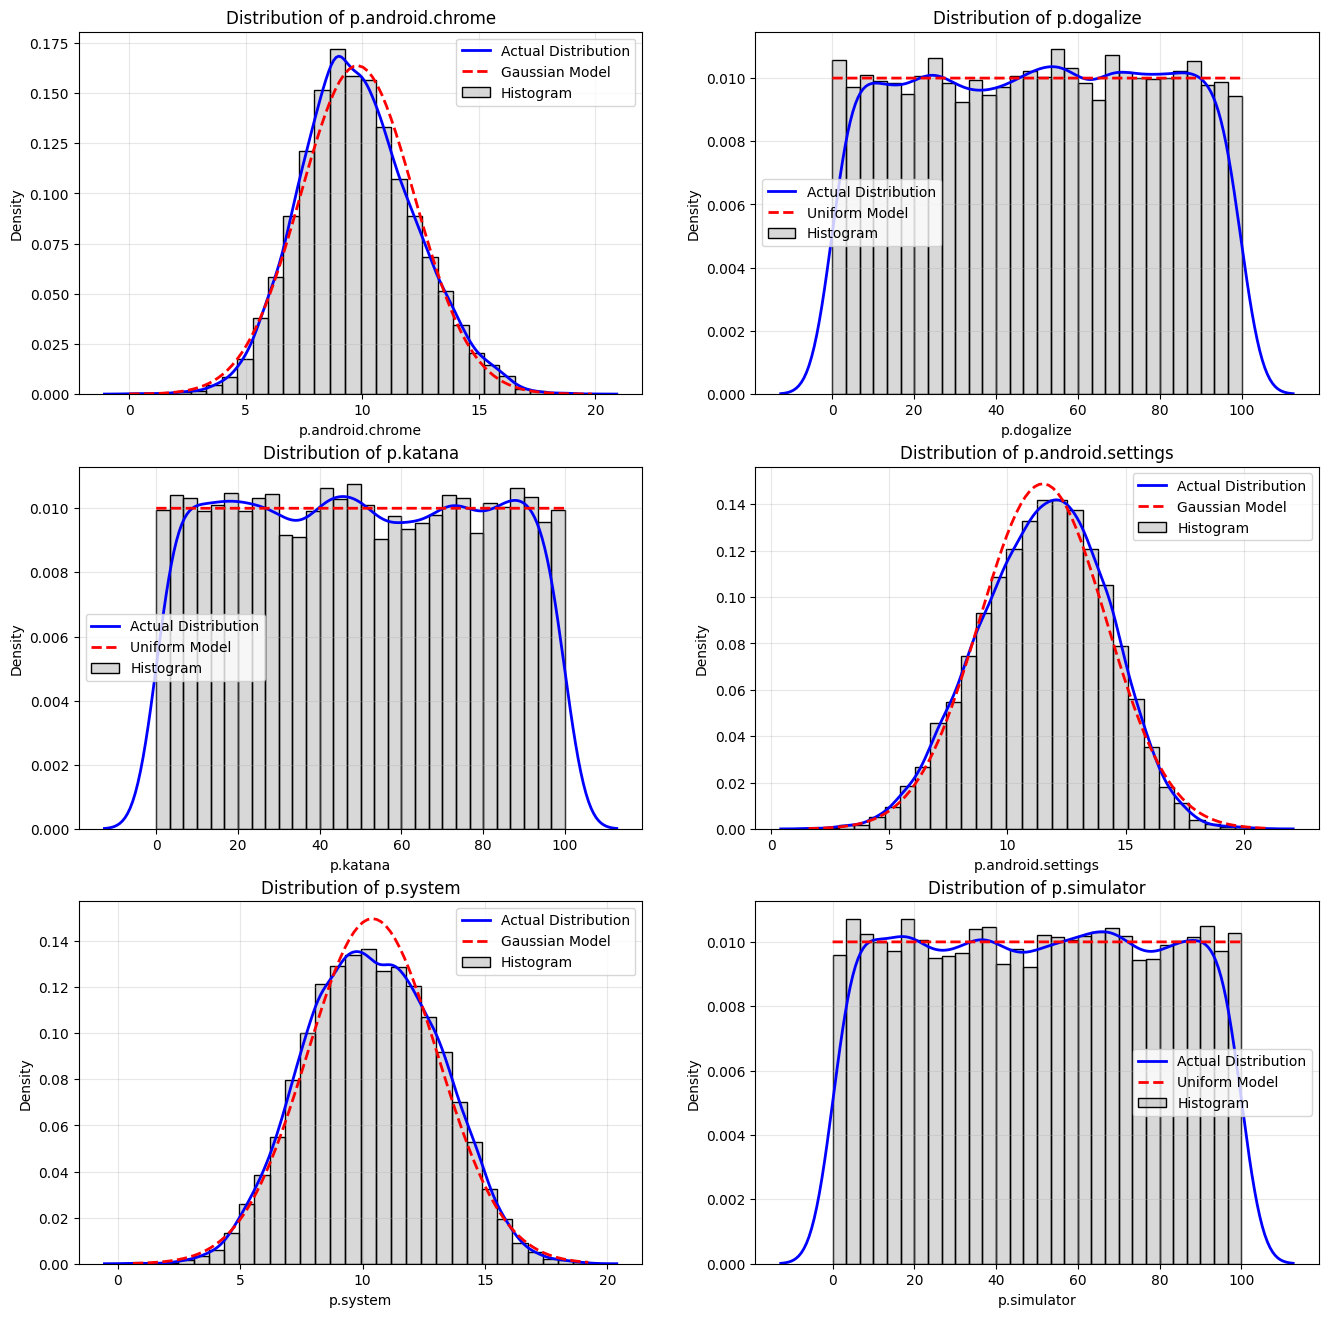

In [40]:
_, axes = plt.subplots(3, 2, figsize=(16, 16))

gaussian_models = [chrome_data, settings_data, system_data]

for i in range(len(all_data_processes)):
    sns.histplot(
        data=all_data_processes[i],
        bins=30,
        stat="density",
        alpha=0.3,
        color="gray",
        label="Histogram",
        ax=axes[i // 2, i % 2],
    )
    sns.kdeplot(
        data=all_data_processes[i],
        color="blue",
        label="Actual Distribution",
        linewidth=2,
        ax=axes[i // 2, i % 2],
    )

    if any(all_data_processes[i] is model for model in gaussian_models):
        x = np.linspace(all_data_processes[i].min(), all_data_processes[i].max(), 100)
        gaussian = stats.norm.pdf(x, all_means_processes[i], all_std_processes[i])
        axes[i // 2, i % 2].plot(
            x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2
        )

    else:
        a = all_data_processes[i].min()
        b = all_data_processes[i].max()
        x = np.linspace(a, b, all_data_processes[i].size)
        uniform_dist = stats.uniform(loc=a, scale=b - a)
        axes[i // 2, i % 2].plot(
            x, uniform_dist.pdf(x), color="red", linestyle="--", label="Uniform Model", linewidth=2
        )

    axes[i // 2, i % 2].set_title(f"Distribution of {all_str_processes[i]}")
    axes[i // 2, i % 2].legend()
    axes[i // 2, i % 2].grid(True, alpha=0.3)

#### Boxplots


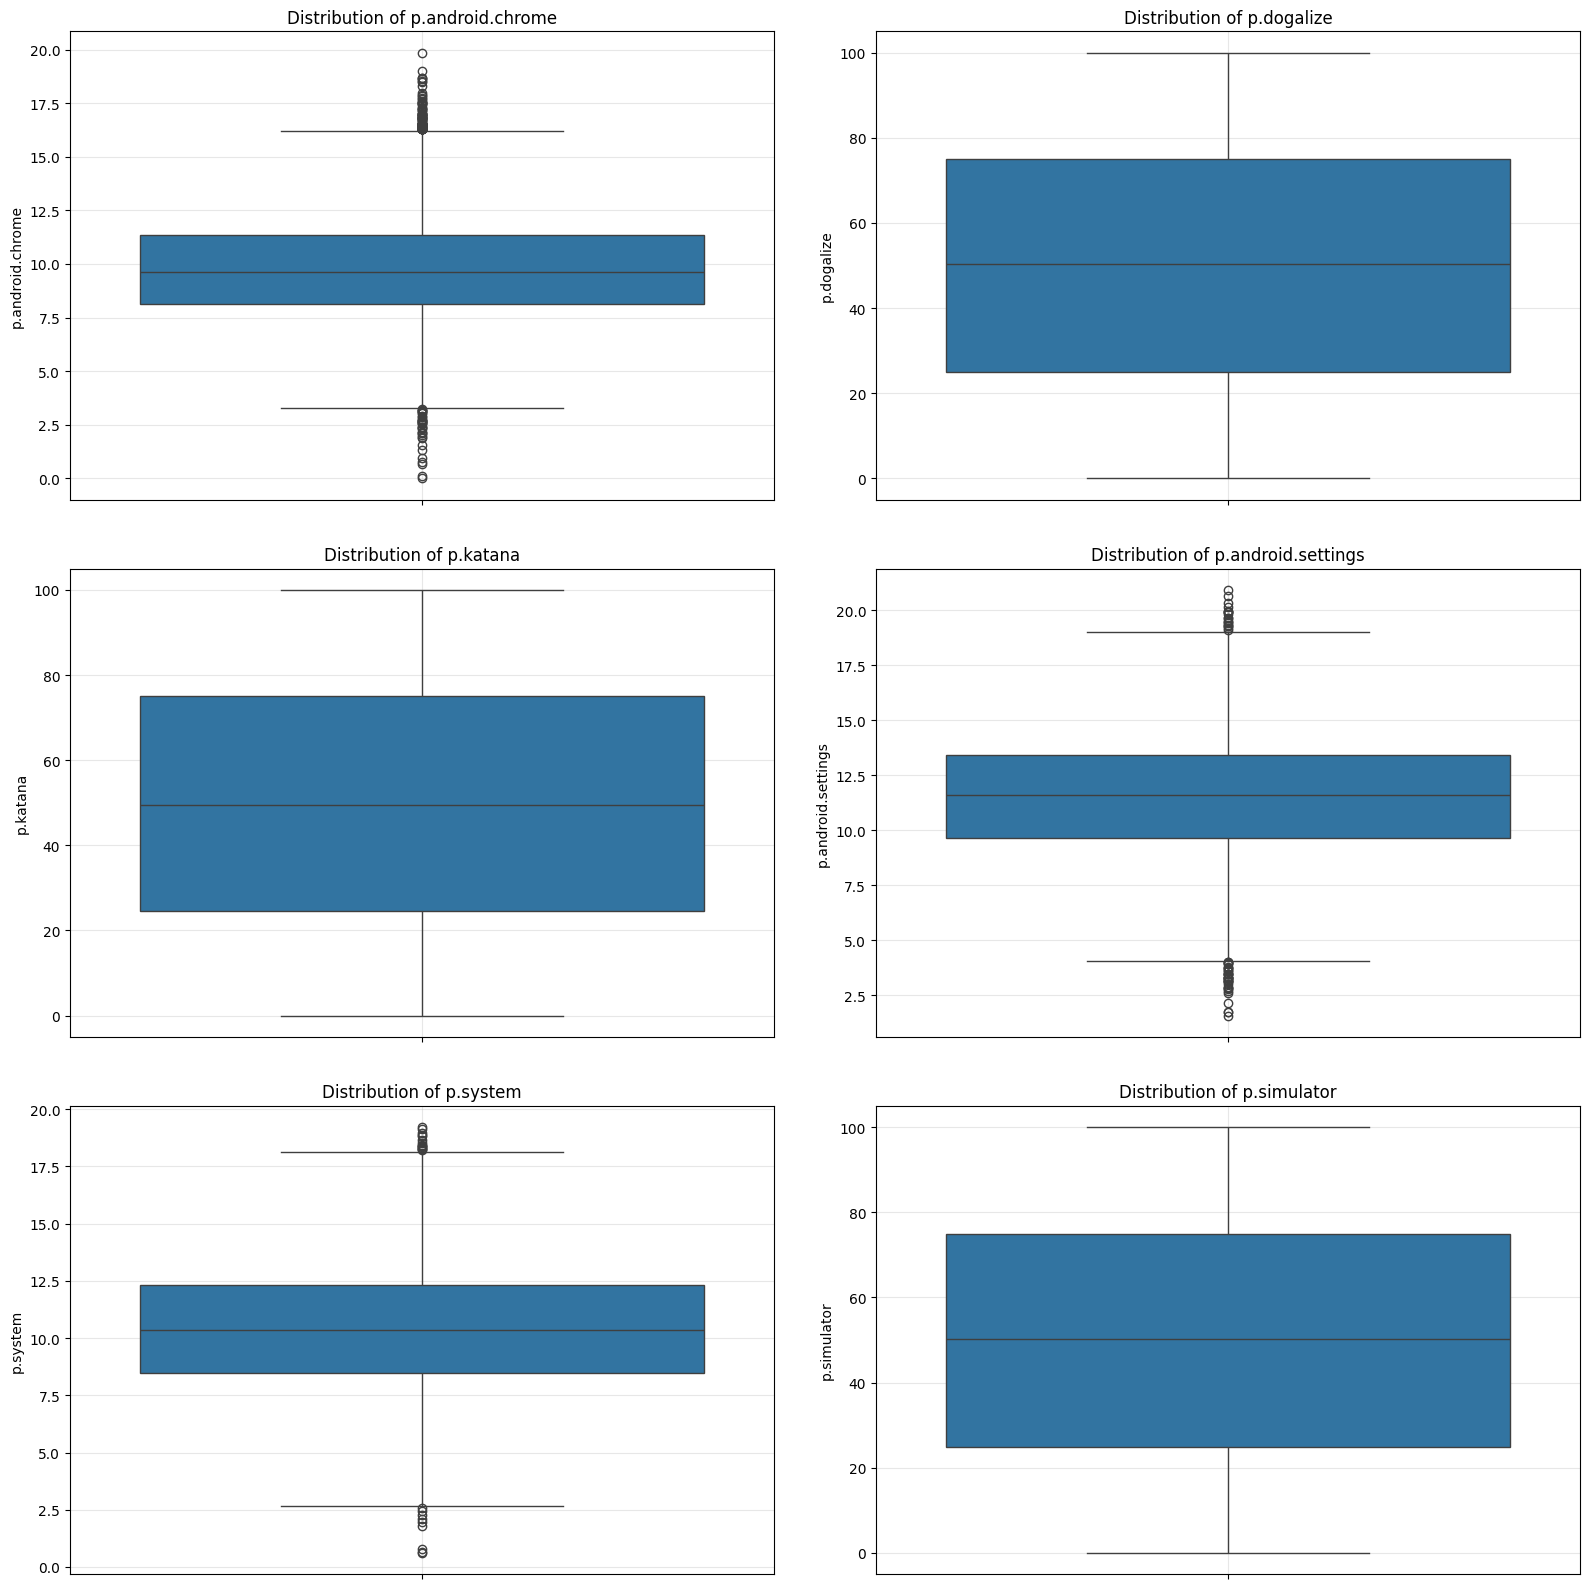

In [41]:
_, axes = plt.subplots(3, 2, figsize=(16, 16))

for i in range(len(all_data_processes)):
    sns.boxplot(all_data_processes[i], ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"Distribution of {all_str_processes[i]}")
    axes[i // 2, i % 2].grid(True, alpha=0.3)


plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

#### Q-Q plots


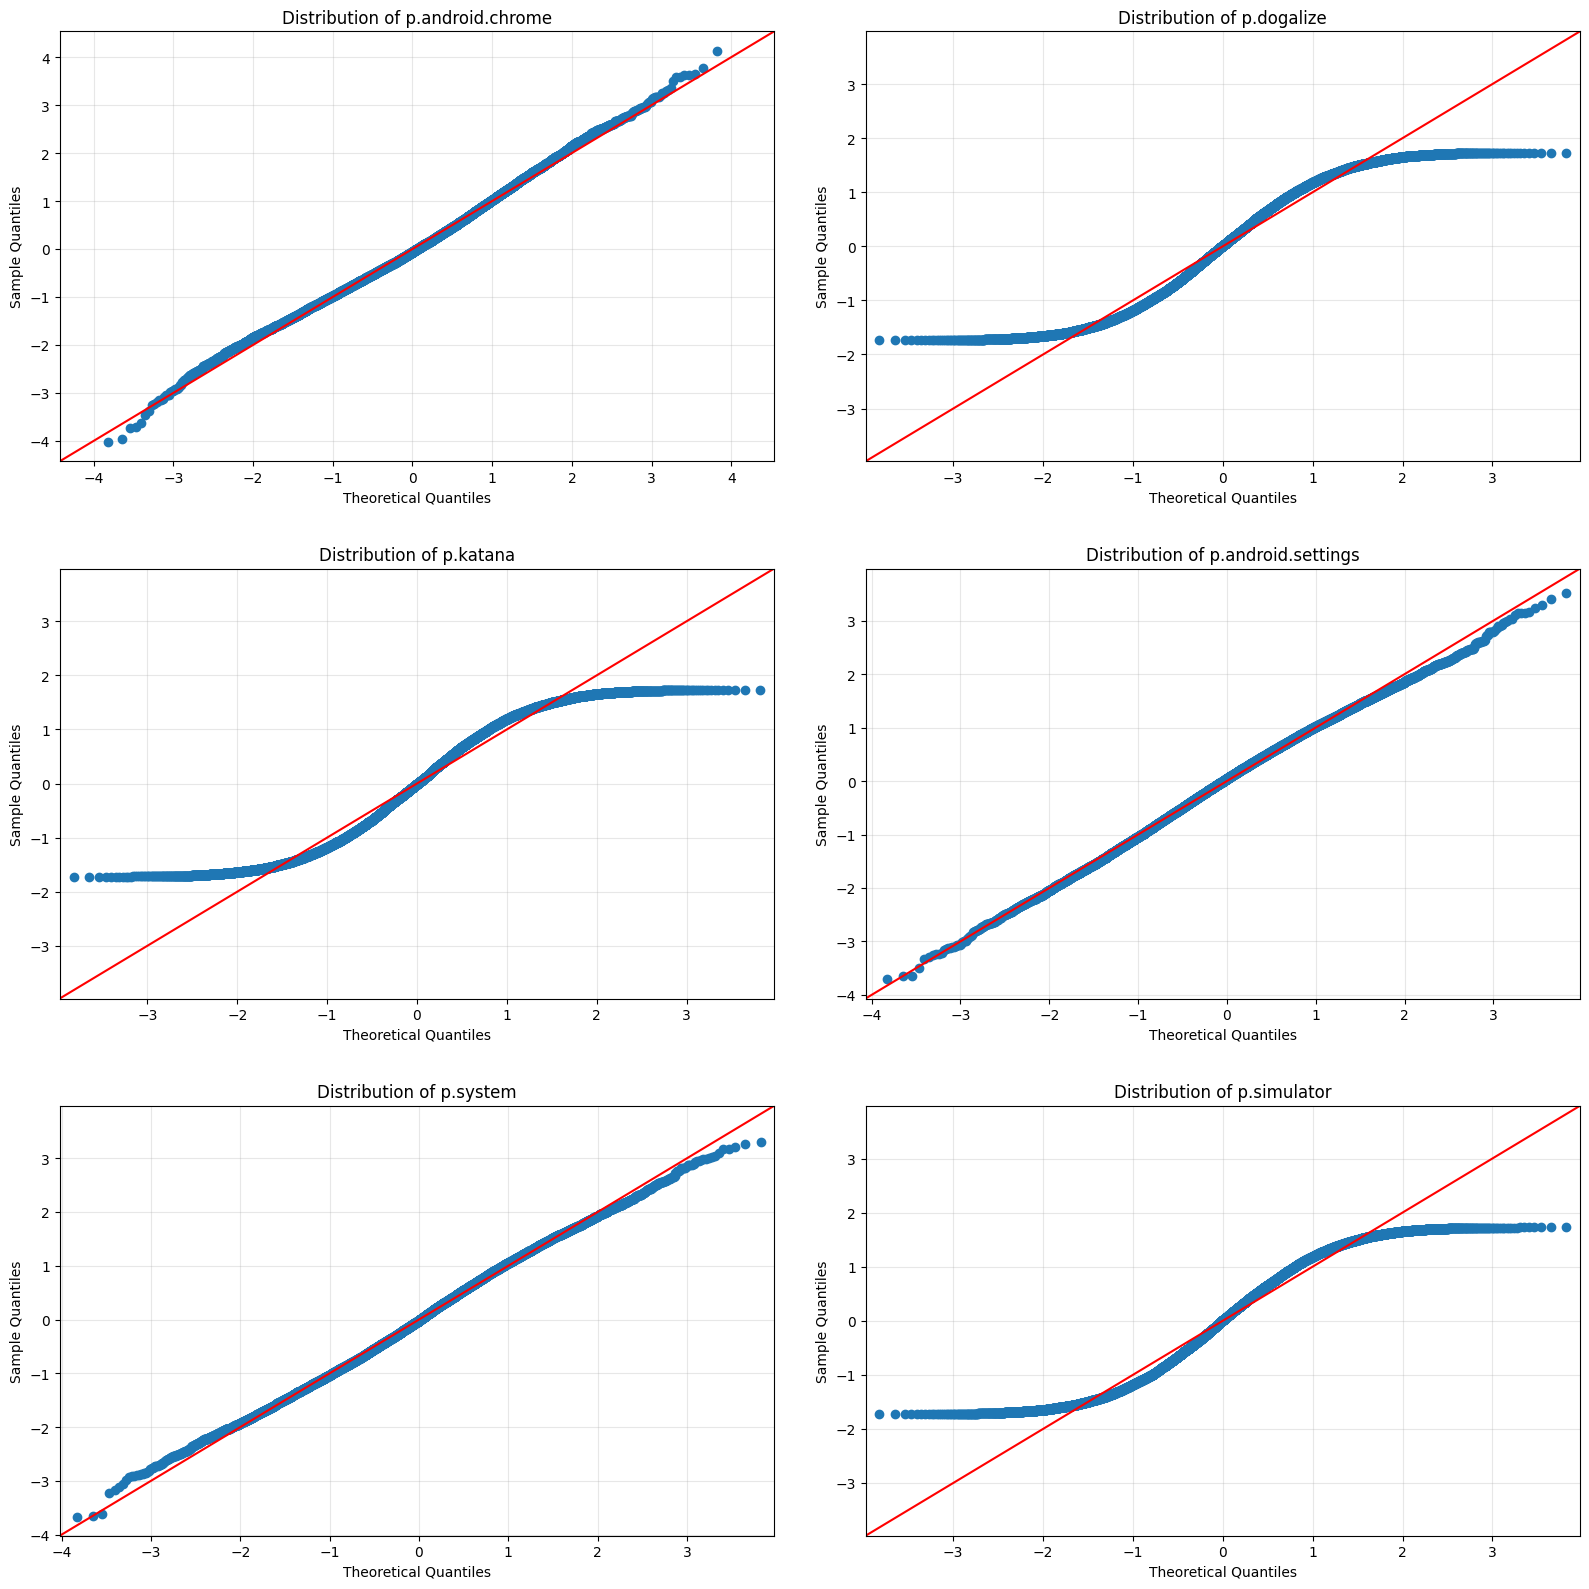

In [42]:
_, axes = plt.subplots(3, 2, figsize=(16, 16))


for i in range(len(all_data_processes)):
    sm.qqplot(all_data_processes[i], fit=True, line="45", ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f"Distribution of {all_str_processes[i]}")
    axes[i // 2, i % 2].grid(True, alpha=0.3)


plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

## C.)


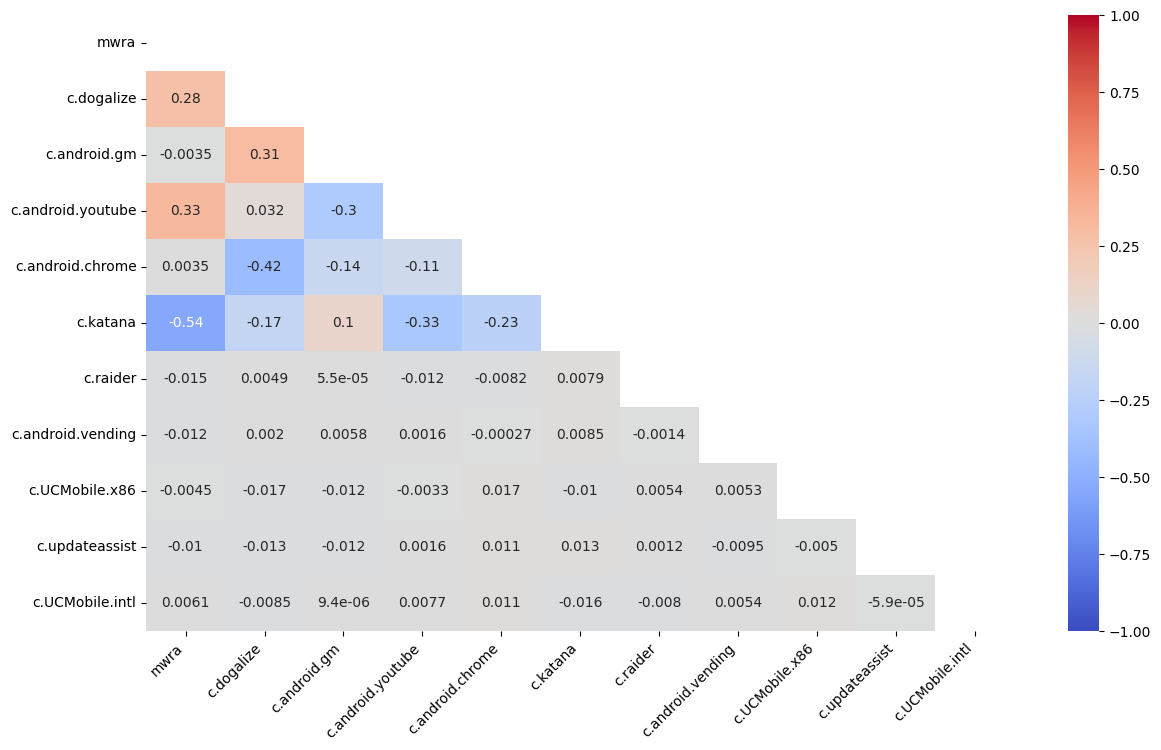

In [43]:
matica = dataset["connections"].iloc[:, 2:].corr()

mask = np.triu(np.ones_like(matica, dtype=bool))
plt.figure(figsize=(14, 8))
sns.heatmap(matica, mask=mask, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(rotation=45, ha="right")
plt.show()

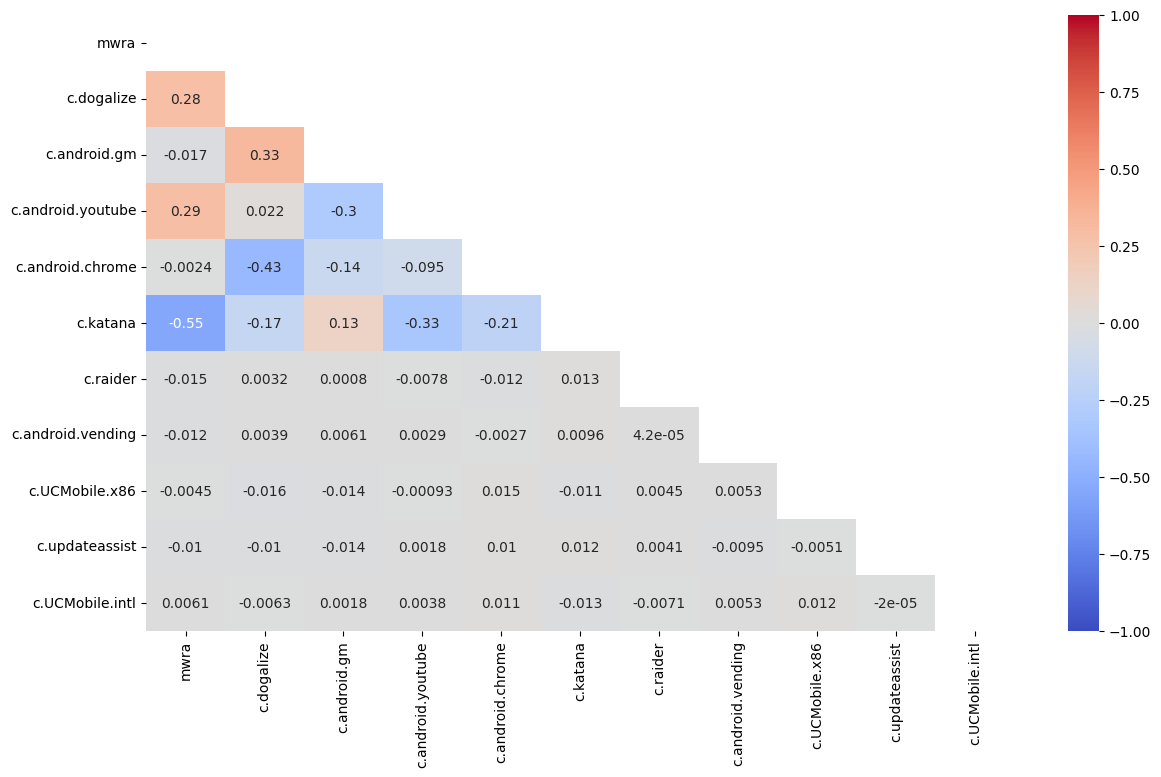

In [44]:
matica = dataset["connections"].iloc[:, 2:].corr(method="spearman")

mask = np.triu(np.ones_like(matica, dtype=bool))
plt.figure(figsize=(14, 8))
sns.heatmap(matica, mask=mask, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

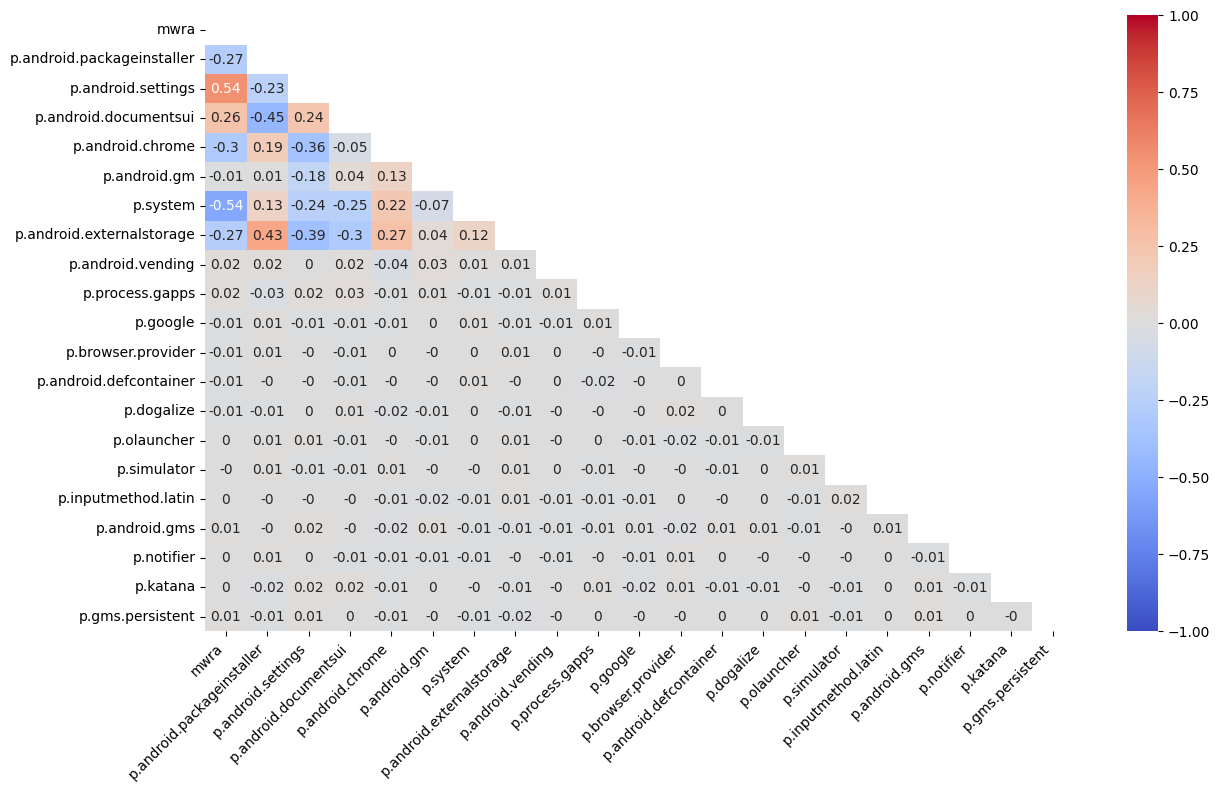

In [45]:
matica = dataset["processes"].iloc[:, 2:].corr()
matica = matica.round(2)

mask = np.triu(np.ones_like(matica, dtype=bool))
plt.figure(figsize=(14, 8))

sns.heatmap(matica, mask=mask, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(rotation=45, ha="right")
plt.show()

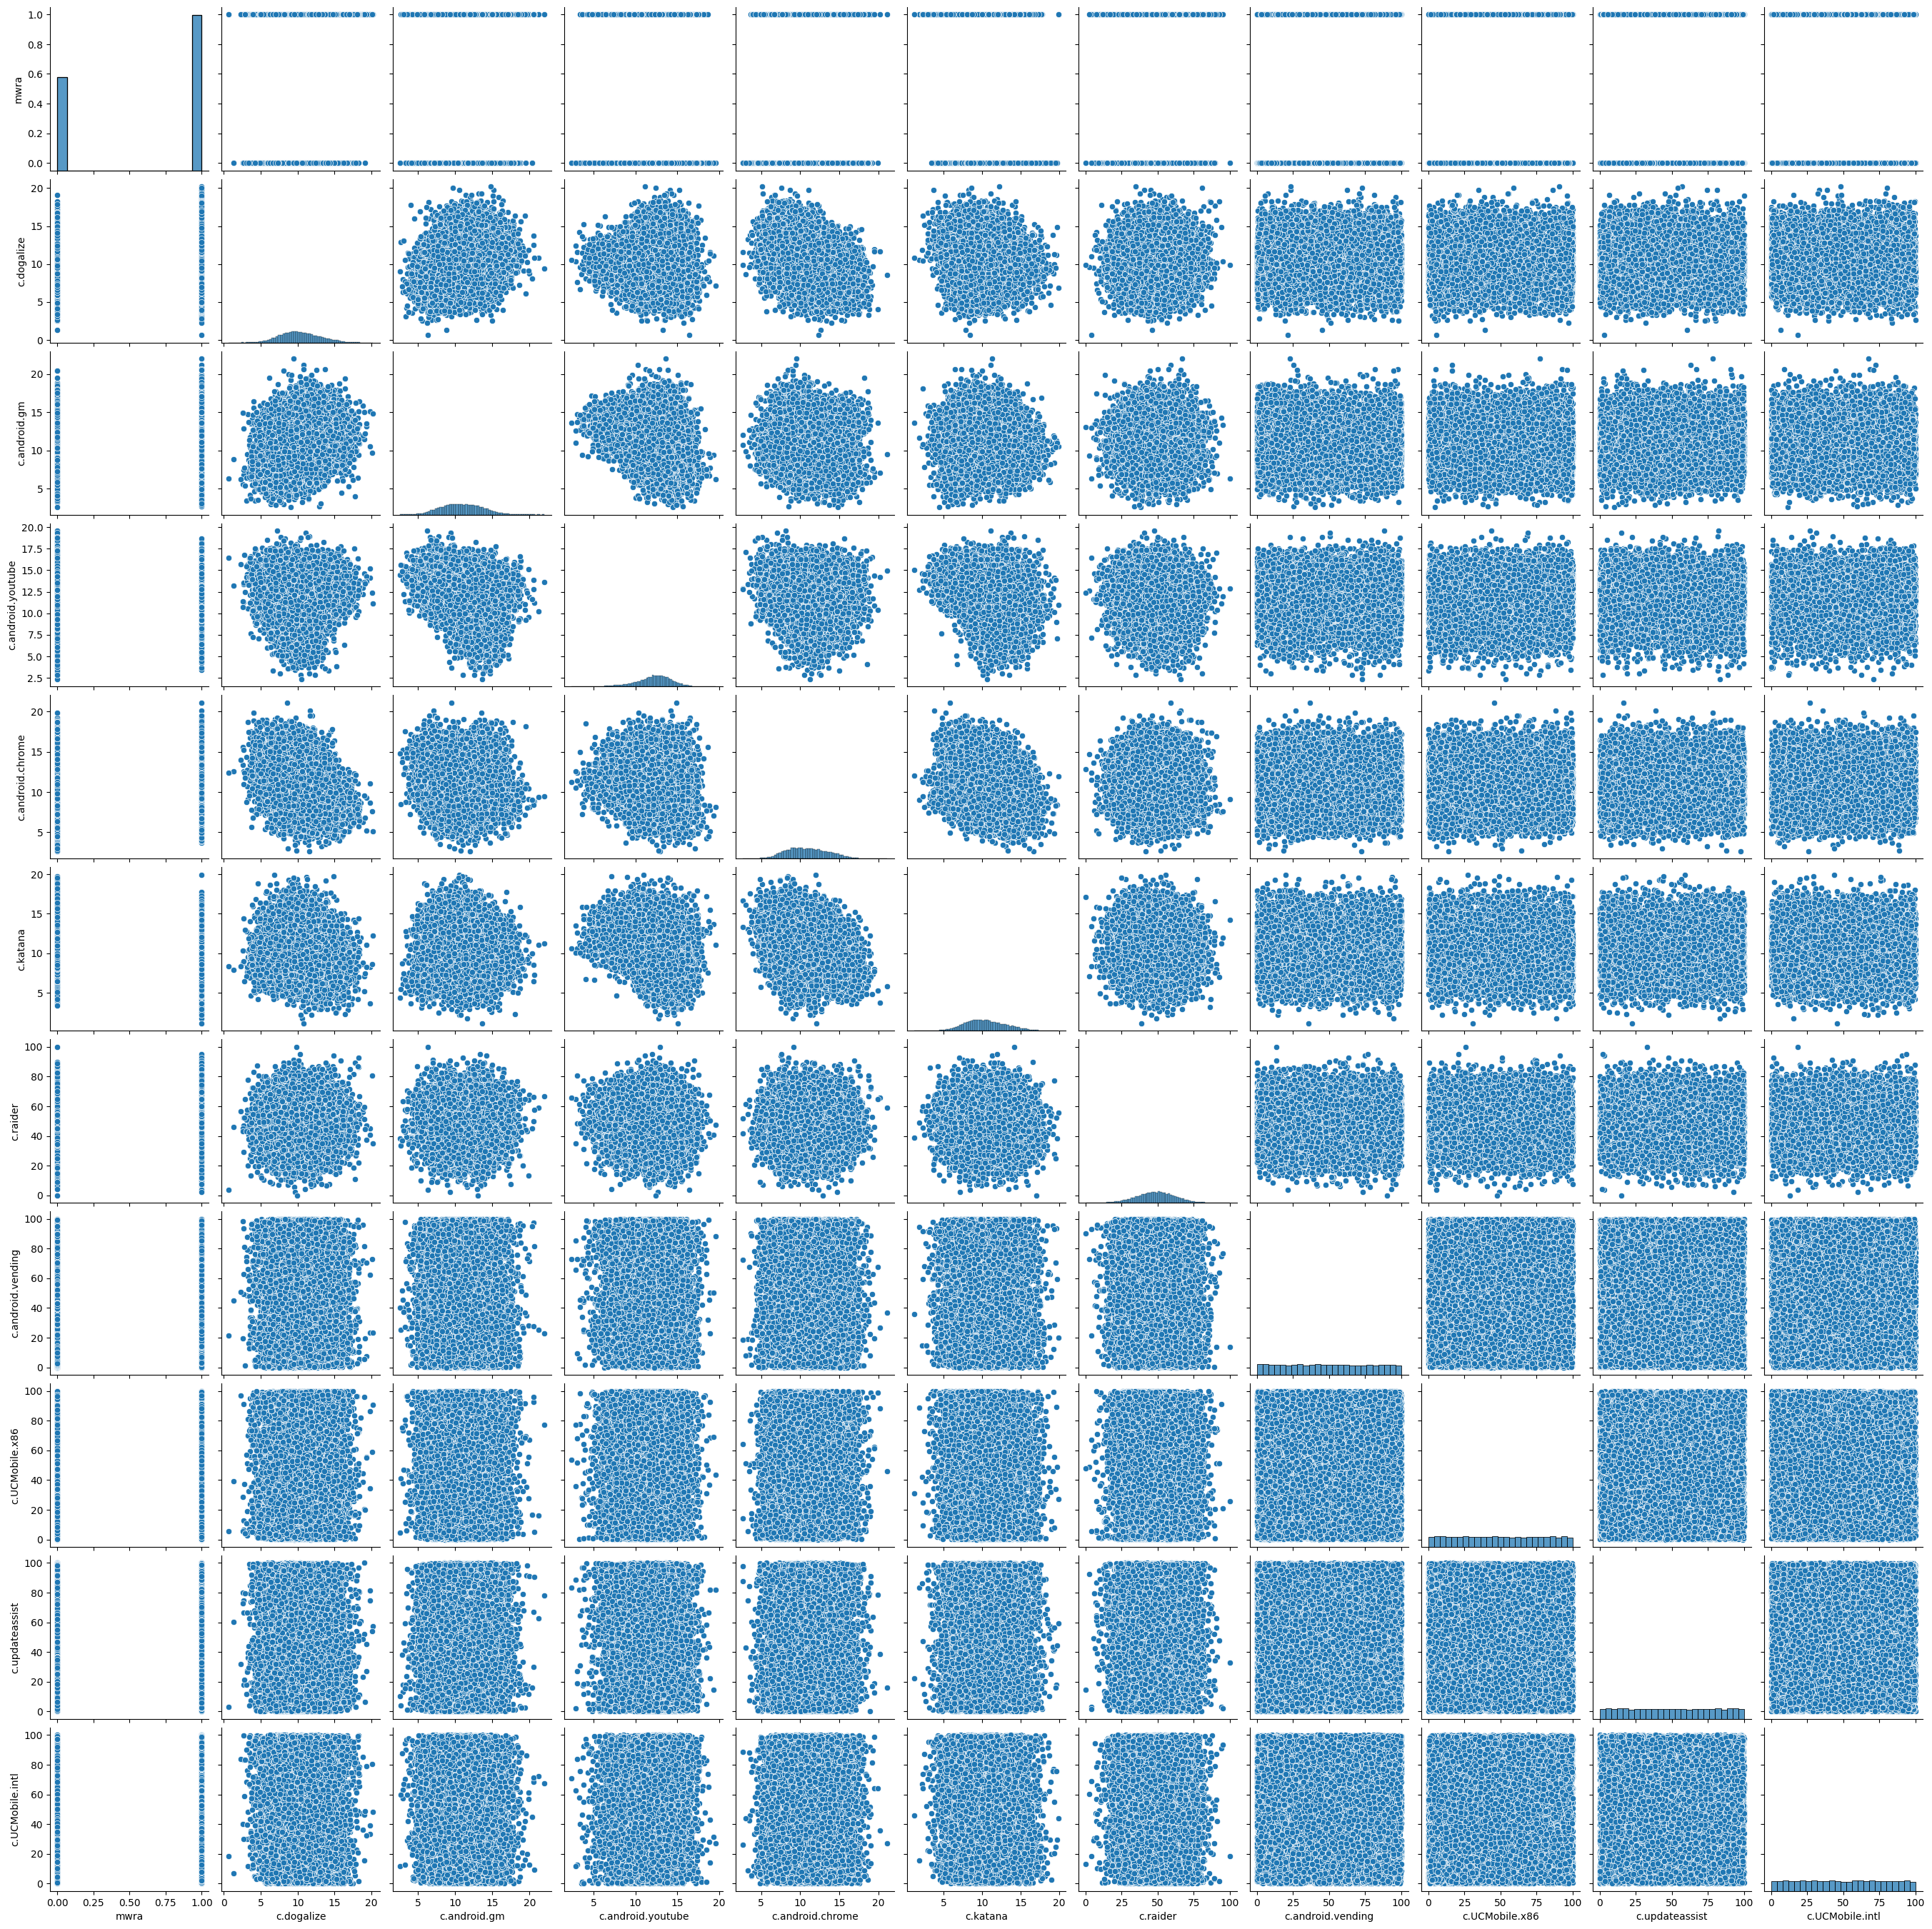

In [46]:
sns.pairplot(dataset["connections"].iloc[:, 2:])
plt.show()

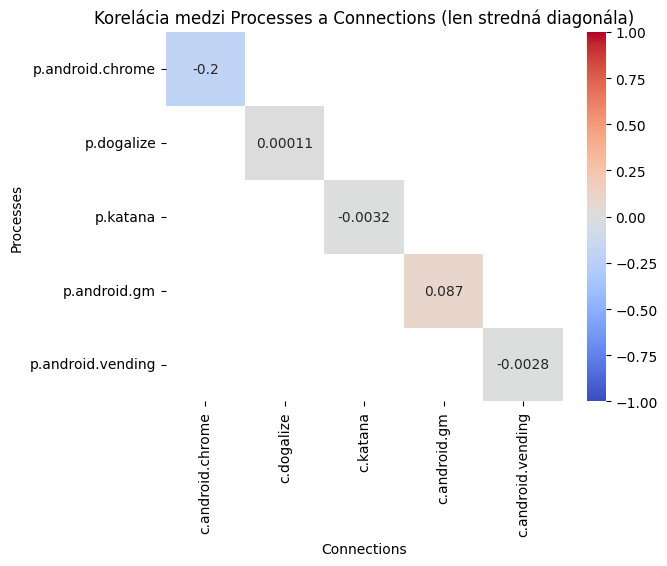

In [47]:
processes_columns = ["p.android.chrome", "p.dogalize", "p.katana", "p.android.gm", "p.android.vending"]
connections_columns = ["c.android.chrome", "c.dogalize", "c.katana", "c.android.gm", "c.android.vending"]

combined_df = pd.concat(
    [dataset["processes"][processes_columns], dataset["connections"][connections_columns]], axis=1
)

correlation_matrix = combined_df.corr(method="pearson")

filtered_corr = correlation_matrix.loc[processes_columns, connections_columns]

mask = np.ones_like(filtered_corr, dtype=bool)
np.fill_diagonal(mask, False)

sns.heatmap(
    filtered_corr,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=connections_columns,
    yticklabels=processes_columns,
)
plt.xlabel("Connections")
plt.ylabel("Processes")
plt.title("Korelácia medzi Processes a Connections (len stredná diagonála)")
plt.show()

<Axes: xlabel='mwra', ylabel='c.katana'>

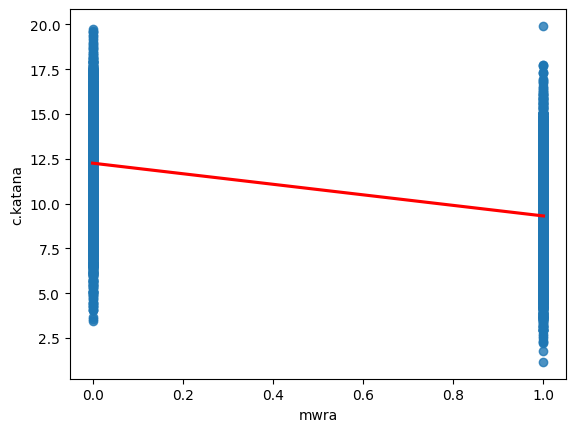

In [48]:
mwra = dataset["connections"]["mwra"]
katana = dataset["connections"]["c.katana"]

sns.regplot(x=mwra, y=katana, line_kws={"color": "red"})

## D.)


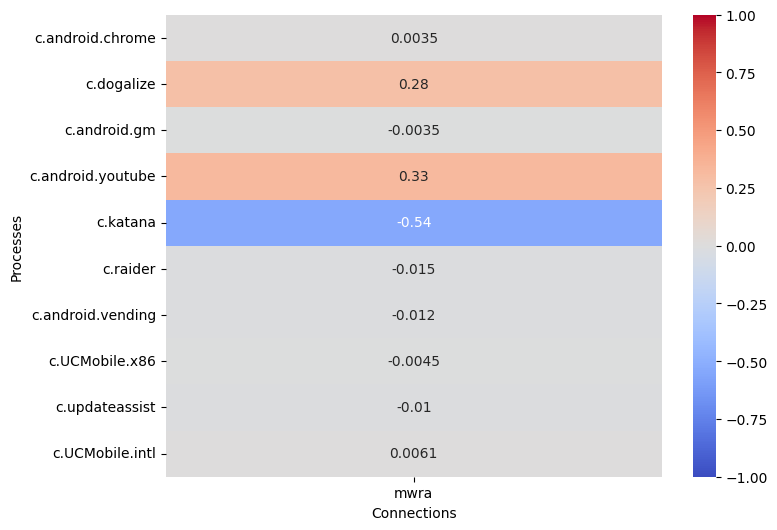

In [49]:
connections_list = all_str_connections
mwra_list = ["mwra"]

combined_df = pd.concat([dataset["connections"][connections_list], dataset["connections"][mwra_list]], axis=1)

correlation_matrix = combined_df.corr(method="pearson")

filtered_corr = correlation_matrix.loc[connections_list, mwra_list]

plt.figure(figsize=(8, 6))
sns.heatmap(
    filtered_corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=mwra_list,
    yticklabels=connections_list,
)
plt.xlabel("Connections")
plt.ylabel("Processes")
plt.show()

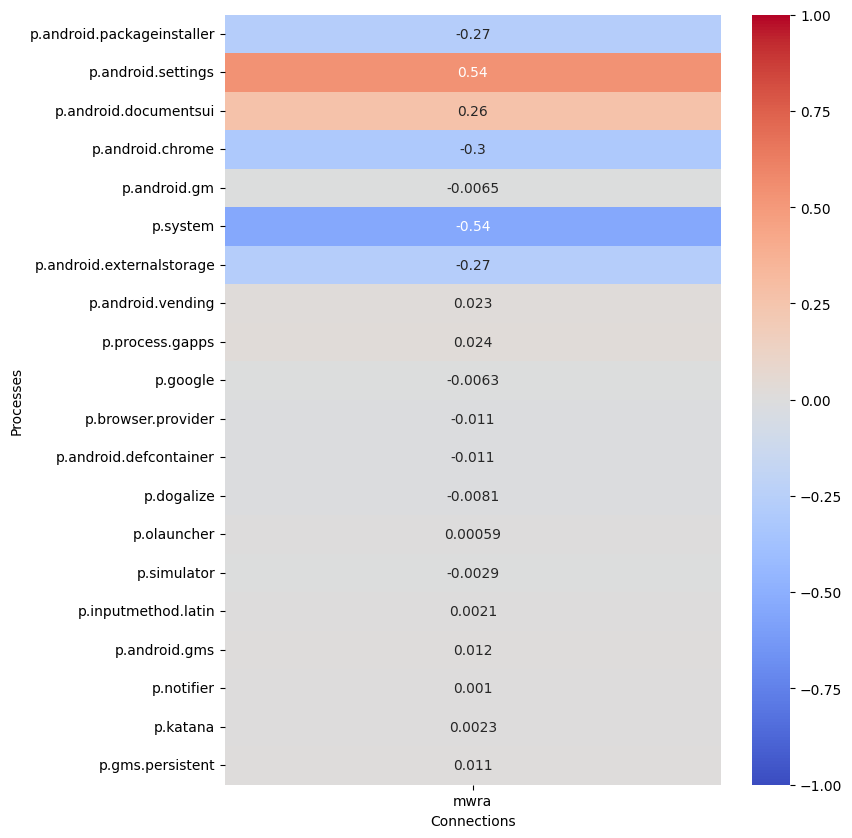

In [50]:
processes_list = dataset["processes"].columns[3:]
mwra_list = ["mwra"]

combined_df = pd.concat([dataset["processes"][processes_list], dataset["processes"][mwra_list]], axis=1)

correlation_matrix = combined_df.corr(method="pearson")

filtered_corr = correlation_matrix.loc[processes_list, mwra_list]

plt.figure(figsize=(8, 10))
sns.heatmap(
    filtered_corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=mwra_list,
    yticklabels=processes_list,
)
plt.xlabel("Connections")
plt.ylabel("Processes")
plt.show()

## E.)


Dokumentujte Vaše prvotné zamyslenie k riešeniu zadania projektu, napr. sú
niektoré atribúty medzi sebou závislé? od ktorých atribútov závisí predikovaná
premenná? či je potrebné kombinovať záznamy z viacerých súborov?


#### Correlations

Connections:

-   Correlation matrix for **mwra** in **connections** shows slight correlations between **c.dogalize** and **c.android.youtube**
-   Surprisingly there is a negative correlation between **c.katana**

Processes:

-   Correlation matrix for **mwra** in **processes** shows slight correlation between **p.android.settings**
-   There is also slight negative correlation between **p.system**

#### Combination of data

-   We can combine data from **connections** and **processes** by **imei** to get more data, especially important data that will be crucial in our model


# 1.2 - Identification of problems, integration and data cleaning


## A.)


In 1.1-A we already transformed the "ts" column to datetime. WIth this we can expect every instance to be of the same format, if there were any errors in the data, the function would throw an error.

But here is also a simple function to check if the data is in the correct format.


In [51]:
def check_correct_format(date: str) -> bool:
    if date[4] == "-" and date[7] == "-" and date[10] == " " and date[13] == ":" and date[16] == ":":
        return True
    print(f"Date {date} is not in correct format")
    return False


# Since we already changed the format of the datetime, we will read cvs again
df = pd.read_csv("../dataset/connections.csv", sep="\t")
bool_val = df["ts"].apply(check_correct_format).all()
print(bool_val)

df = pd.read_csv("../dataset/processes.csv", sep="\t")
bool_val = df["ts"].apply(check_correct_format).all()
print(bool_val)

True
True


In [52]:
for key in dataset:
    has_missing_values = dataset[key].isnull().values.any()
    print(
        f"DataFrame {key:<12} has {dataset[key].isnull().sum().sum() if has_missing_values else 'no':<4} missing values"
    )

DataFrame connections  has no   missing values
DataFrame devices      has no   missing values
DataFrame processes    has no   missing values
DataFrame profiles     has 5014 missing values


-   We see that **profiles** have some missing values


In [53]:
missing_columns = dataset["profiles"].columns[dataset["profiles"].isnull().any()]
print("Columns with missing values:", missing_columns)

dataset["profiles"][dataset["profiles"].isnull().any(axis=1)][missing_columns].sample(10)
dataset["profiles"].info()

Columns with missing values: Index(['address', 'job', 'residence', 'birthdate'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2571 entries, 0 to 2570
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   username      2571 non-null   object        
 1   address       2185 non-null   object        
 2   name          2571 non-null   object        
 3   user_id       2571 non-null   int64         
 4   job           771 non-null    object        
 5   ssn           2571 non-null   object        
 6   company       2571 non-null   object        
 7   imei          2571 non-null   int64         
 8   registration  2571 non-null   object        
 9   residence     900 non-null    object        
 10  mail          2571 non-null   object        
 11  birthdate     1414 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 241.2+ KB


-   We can see the columns with missing values in **profiles** are "adress", "job", "residence", "birthdate"
-   These columns hold no important information for our analysis


In [54]:
for key in dataset:
    has_duplicates = dataset[key].duplicated().any()
    print(
        f'DataFrame {key:<12} has {dataset[key].duplicated().sum() if has_duplicates else "no":<4} duplicates'
    )

DataFrame connections  has 179  duplicates
DataFrame devices      has 8    duplicates
DataFrame processes    has 179  duplicates
DataFrame profiles     has no   duplicates


Duplicates in **connections**


In [55]:
dataset["connections"][dataset["connections"].duplicated(keep="first")].sample(5, random_state=42)

ts                 imei  mwra  c.dogalize  \
15007 2018-05-11 07:17:00  3590433799317661560   1.0    13.74670   
14945 2018-05-14 09:27:00  8630330696303482477   1.0     7.64339   
14994 2018-05-12 19:18:00  8630330696303481917   1.0    11.15762   
15043 2018-05-09 10:45:00   863033069630348446   1.0    11.75566   
15005 2018-05-13 10:13:00  3590433799317662071   0.0    13.77876   

       c.android.gm  c.android.youtube  c.android.chrome  c.katana  c.raider  \
15007      14.21147           13.15895           7.36484  13.50045  35.41008   
14945       5.23483           16.11463           7.39804  16.08968  49.15484   
14994       7.10923           13.74889          11.06788  10.26652  60.23011   
15043       7.59384           10.60851          16.91253   6.51789  41.95181   
15005      13.13525           11.40291          11.62671  11.37855  44.30387   

       c.android.vending  c.UCMobile.x86  c.updateassist  c.UCMobile.intl  
15007           50.42166        62.62643         1.91424         43.63961  
14945           93.79111        59.01928        47.96783         85.56507  
14994           41.08359        25.76514        80.54159         69.53177  
15043           77.43390        35.92050        83.15685          2.72883  
15005           52.41606         0.40807        46.68585         76.65642

Duplicates in **devices**


In [56]:
dataset["devices"][dataset["devices"].duplicated(keep="first")]

latitude  longitude           store_name code             location  \
540    9.89206   43.38531                 Baki   SO     Africa/Mogadishu   
890   34.25000  135.31667                Iwade   JP           Asia/Tokyo   
895    3.72780   98.67380         Labuhan Deli   ID         Asia/Jakarta   
1105  52.14000    5.58472            Barneveld   NL     Europe/Amsterdam   
1866  23.29549  113.82465              Licheng   CN        Asia/Shanghai   
1987  39.09112  -94.41551         Independence   US      America/Chicago   
2397  19.64745 -102.04897  Paracho de Verduzco   MX  America/Mexico_City   
2458  53.46506   -1.47217           Chapletown   GB        Europe/London   

                     imei  
540   3590433799317662188  
890   3590433799317661305  
895    359043379931766064  
1105   863033069630348685  
1866  8630330696303481248  
1987   863033069630348149  
2397   359043379931766395  
2458  8630330696303482287

Duplicates in **processes**


In [57]:
dataset["processes"][dataset["processes"].duplicated(keep="first")].sample(5, random_state=42)

ts                 imei  mwra  \
15007 2018-05-11 07:17:00  3590433799317661560   1.0   
14945 2018-05-14 09:27:00  8630330696303482477   1.0   
14994 2018-05-12 19:18:00  8630330696303481917   1.0   
15043 2018-05-09 10:45:00   863033069630348446   1.0   
15005 2018-05-13 10:13:00  3590433799317662071   0.0   

       p.android.packageinstaller  p.android.settings  p.android.documentsui  \
15007                    13.42560            12.17056               12.25201   
14945                    13.57180            12.58168                9.89711   
14994                    11.91895            12.88448                9.67488   
15043                     8.94452             7.24115               13.94512   
15005                    10.55606            11.66152               10.50462   

       p.android.chrome  p.android.gm  p.system  p.android.externalstorage  \
15007          10.47155      14.30791   6.04071                   16.02382   
14945          15.15258      10.06558  14.26822                    7.72121   
14994           5.97060       9.94093   8.10144                    9.60267   
15043          11.91765      12.92797   5.31245                   12.28907   
15005          12.45389      14.81260   9.91842                   10.84095   

       ...  p.browser.provider  p.android.defcontainer  p.dogalize  \
15007  ...            56.05136                17.86507    61.89882   
14945  ...            50.56476                45.69149    92.44527   
14994  ...            70.91633                38.64310    79.55268   
15043  ...            59.74771                51.59156    93.48889   
15005  ...            58.87135                57.46057    20.57100   

       p.olauncher  p.simulator  p.inputmethod.latin  p.android.gms  \
15007     22.99826     16.20689             25.75929       46.09183   
14945     82.15229     86.18336             50.44844       36.59208   
14994     82.35012     10.74775             24.28545       53.62309   
15043     55.37114     98.57215             92.73975       50.10673   
15005     56.71212      5.02172             39.91221       26.63488   

       p.notifier  p.katana  p.gms.persistent  
15007    54.48928  31.47550          22.15268  
14945    76.03880  21.74252          10.60075  
14994    98.74651  84.82156          77.97133  
15043    96.30238   4.66615           7.68150  
15005    42.69189  33.86899           3.00348  

[5 rows x 23 columns]

## B.)


In [58]:
profiles_copy = dataset["profiles"].copy()

before_drop = profiles_copy.isnull().sum().sum()
profiles_copy.dropna(inplace=True)

after_drop = profiles_copy.isnull().sum().sum()

print(f"DataFrame profiles had {before_drop} missing values, after drop {after_drop}")

DataFrame profiles had 5014 missing values, after drop 0


-   Based on the data, after using first technique, that of a dropping rows with nan in them, we successfully removed all missing values from the **profiles** dataset


In [59]:
profiles_copy = dataset["profiles"].copy()

before_manipulating = profiles_copy.isnull().sum().sum()
number_of_rows = len(profiles_copy)
number_of_values = profiles_copy.count().sum()
missing_values = profiles_copy.isnull().sum().sum()

profiles_copy["job"].fillna(profiles_copy["job"].mode()[0], inplace=True)  # using mode
profiles_copy["residence"].fillna(profiles_copy["residence"].mode()[0], inplace=True)

profiles_copy["birth_year"] = profiles_copy["birthdate"].dt.year  # taking out the year
profiles_copy["birth_year"] = profiles_copy["birth_year"].interpolate(method="linear")  # using interpolation

profiles_copy["birthdate"] = pd.to_datetime(
    profiles_copy["birth_year"].round().astype(int), format="%Y", errors="coerce"
)
profiles_copy.drop(columns="birth_year", inplace=True)


le_residence = LabelEncoder()
profiles_copy["residence_encoded"] = le_residence.fit_transform(
    profiles_copy["residence"].astype(str)
)  # Encoding

le_address = LabelEncoder()
profiles_copy["address_encoded"] = le_address.fit_transform(
    profiles_copy["address"].fillna("NaN").astype(str)
)  # keeping the values

subset = profiles_copy[["address_encoded", "residence_encoded"]]
subset.loc[profiles_copy["address"].isnull(), "address_encoded"] = np.nan

imputer = KNNImputer(n_neighbors=2)
subset_imputed = imputer.fit_transform(subset)  # using kNN

profiles_copy["address_encoded"] = subset_imputed[:, 0]
profiles_copy["address"] = le_address.inverse_transform(profiles_copy["address_encoded"].round().astype(int))

profiles_copy.drop(columns=["address_encoded", "residence_encoded"], inplace=True)

after_manipulating = profiles_copy.isnull().sum().sum()
number_of_rows_new = len(profiles_copy)
number_of_values_new = profiles_copy.count().sum()
missing_values_new = profiles_copy.isnull().sum().sum()

print(
    f"Before manipulating: {before_manipulating} nan rows, after manipulating: {after_manipulating} nan rows"
)
print(f"Number of rows before: {number_of_rows}, after: {number_of_rows_new}")
print(
    f"Number of values before: {number_of_values} + {missing_values} missing ({number_of_values + missing_values}), after: {number_of_values_new} + {missing_values_new} missing ({number_of_values_new + missing_values_new})"
)
profiles_copy

Before manipulating: 5014 nan rows, after manipulating: 0 nan rows
Number of rows before: 2571, after: 2571
Number of values before: 25838 + 5014 missing (30852), after: 30852 + 0 missing (30852)


C:\Users\mario\AppData\Local\Temp\ipykernel_14880\3971797389.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  profiles_copy["job"].fillna(profiles_copy["job"].mode()[0], inplace=True)  # using mode
C:\Users\mario\AppData\Local\Temp\ipykernel_14880\3971797389.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

username                                            address  \
0          nancywagner                 Unit 3496 Box 9846\r\nDPO AE 23667   
1         millerdakota    677 Jay Vista Suite 015\r\nBrownhaven, LA 18432   
2         meyerabigail  3746 Baldwin Estate Suite 335\r\nWest Travis, ...   
3          timothyhart  8748 Villarreal Lights\r\nWest Michaelfurt, WA...   
4     jenniferwilliams            499 Michael Flat\r\nJesseview, HI 05817   
...                ...                                                ...   
2566        ballaustin  657 Russell Parks Suite 804\r\nJosephtown, WV ...   
2567             ohood  38857 Matthew Mission Suite 231\r\nMichaelport...   
2568     arianaeverett  9420 Gilmore Crest Suite 916\r\nDeborahstad, O...   
2569   edwardsjennifer       2913 Hill Glens\r\nNew Douglasfurt, RI 84694   
2570      teresamorgan  336 Johnson Ranch Apt. 686\r\nPort Lisa, HI 55014   

                   name  user_id                               job  \
0         Shelly Thomas     1713               Magazine journalist   
1              Amy Horn     1886               Magazine journalist   
2         Leah Campbell      184               Magazine journalist   
3         Joseph Miller      920      Fast food restaurant manager   
4     Kimberly Williams     2557               Magazine journalist   
...                 ...      ...                               ...   
2566     Scott Thompson      149  Education officer, environmental   
2567        Andrea Owen     2310                Facilities manager   
2568        David Garza     2234               Magazine journalist   
2569      Sean Martinez     1241               Magazine journalist   
2570      Patricia West     1760               Magazine journalist   

              ssn                         company                 imei  \
0     568-30-2539         Miller, Kirby and Davis   863033069630348636   
1     395-74-2254  Gonzalez, Andrade and Robinson   359043379931766007   
2     848-91-2310       Boyle, Taylor and Sampson  8630330696303481487   
3     247-95-0332                 Smith-Rodriguez  8630330696303481156   
4     162-02-9998                Ramsey-Fernandez  8630330696303481453   
...           ...                             ...                  ...   
2566  161-68-2165                 Holder and Sons  3590433799317661172   
2567  288-59-2484          King, Hardy and Bishop  8630330696303482451   
2568  136-97-3244                  Freeman-Garcia   863033069630348057   
2569  627-93-0176       Santiago, Hudson and Ruiz  3590433799317661081   
2570  481-99-3476        Turner, Butler and Patel  8630330696303481644   

              registration                                          residence  \
0              02 Aug 2018            000 Walsh Drive\r\nNorth Ryan, TX 06021   
1              18 Feb 2022            000 Walsh Drive\r\nNorth Ryan, TX 06021   
2               2021/08/17            000 Walsh Drive\r\nNorth Ryan, TX 06021   
3               2023-10-24  864 Jared Overpass Suite 869\r\nPort Amanda, W...   
4               2018-03-19            000 Walsh Drive\r\nNorth Ryan, TX 06021   
...                    ...                                                ...   
2566           07 Apr 2023            000 Walsh Drive\r\nNorth Ryan, TX 06021   
2567            2019-08-15  218 Snyder Trail Suite 365\r\nWhiteburgh, SD 1...   
2568  03/21/2018, 00:00:00            000 Walsh Drive\r\nNorth Ryan, TX 06021   
2569  12/17/2023, 00:00:00  6654 Ryan Wells Apt. 100\r\nMadisonburgh, GU 6...   
2570            2019-06-19  30810 Knight Dale Apt. 716\r\nWest Jessicahave...   

                          mail  birthdate  
0     brandonsmith@hotmail.com 2004-01-01  
1         keithgibbs@gmail.com 1931-01-01  
2            steve72@yahoo.com 1931-01-01  
3        mfletcher@hotmail.com 1955-01-01  
4       ryanmartinez@yahoo.com 1966-01-01  
...                        ...        ...  
2566      kristy78@hotmail.com 1979-01-01  
2567   veronicahicks@gmail.com 192

## C.)


<Axes: >

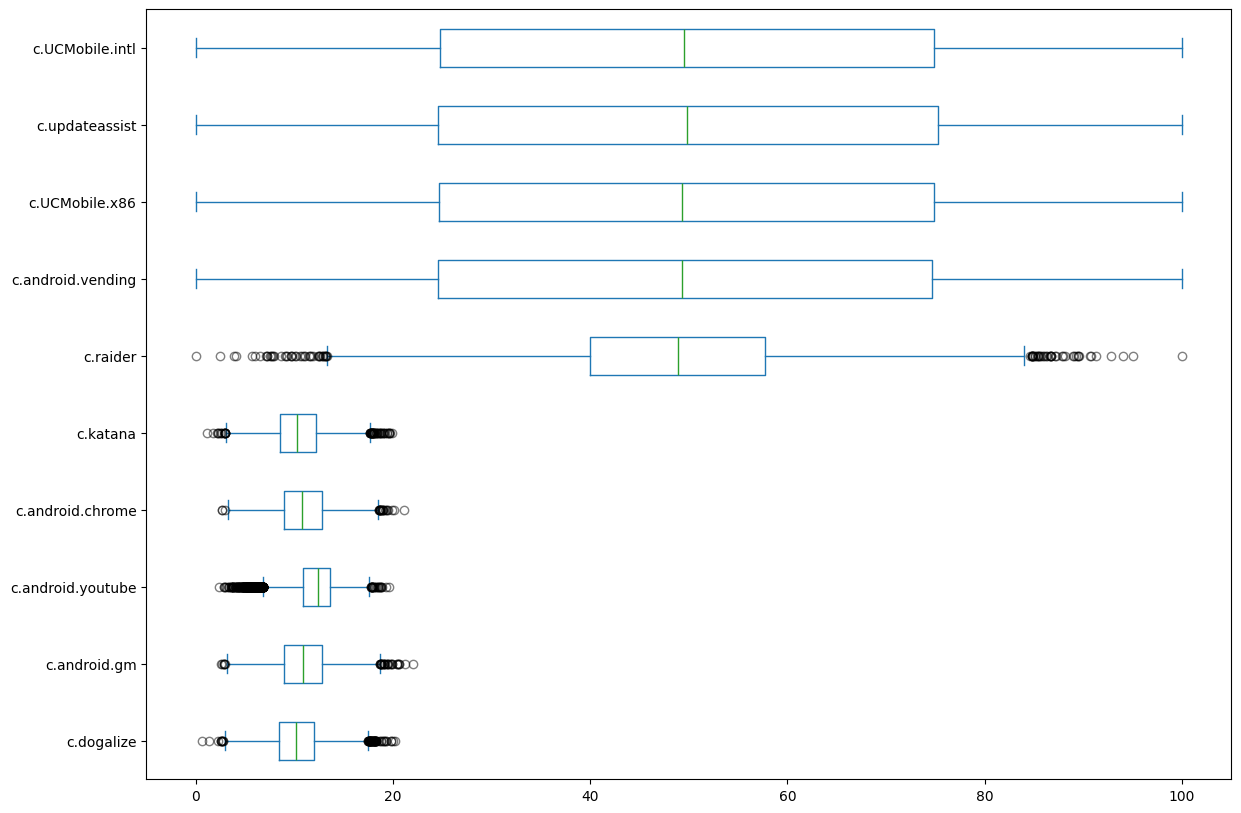

In [60]:
dataset["connections"].iloc[:, 3:].plot(
    kind="box", vert=False, figsize=(14, 10), flierprops=dict(marker="o", color="r", alpha=0.5)
)

<Axes: >

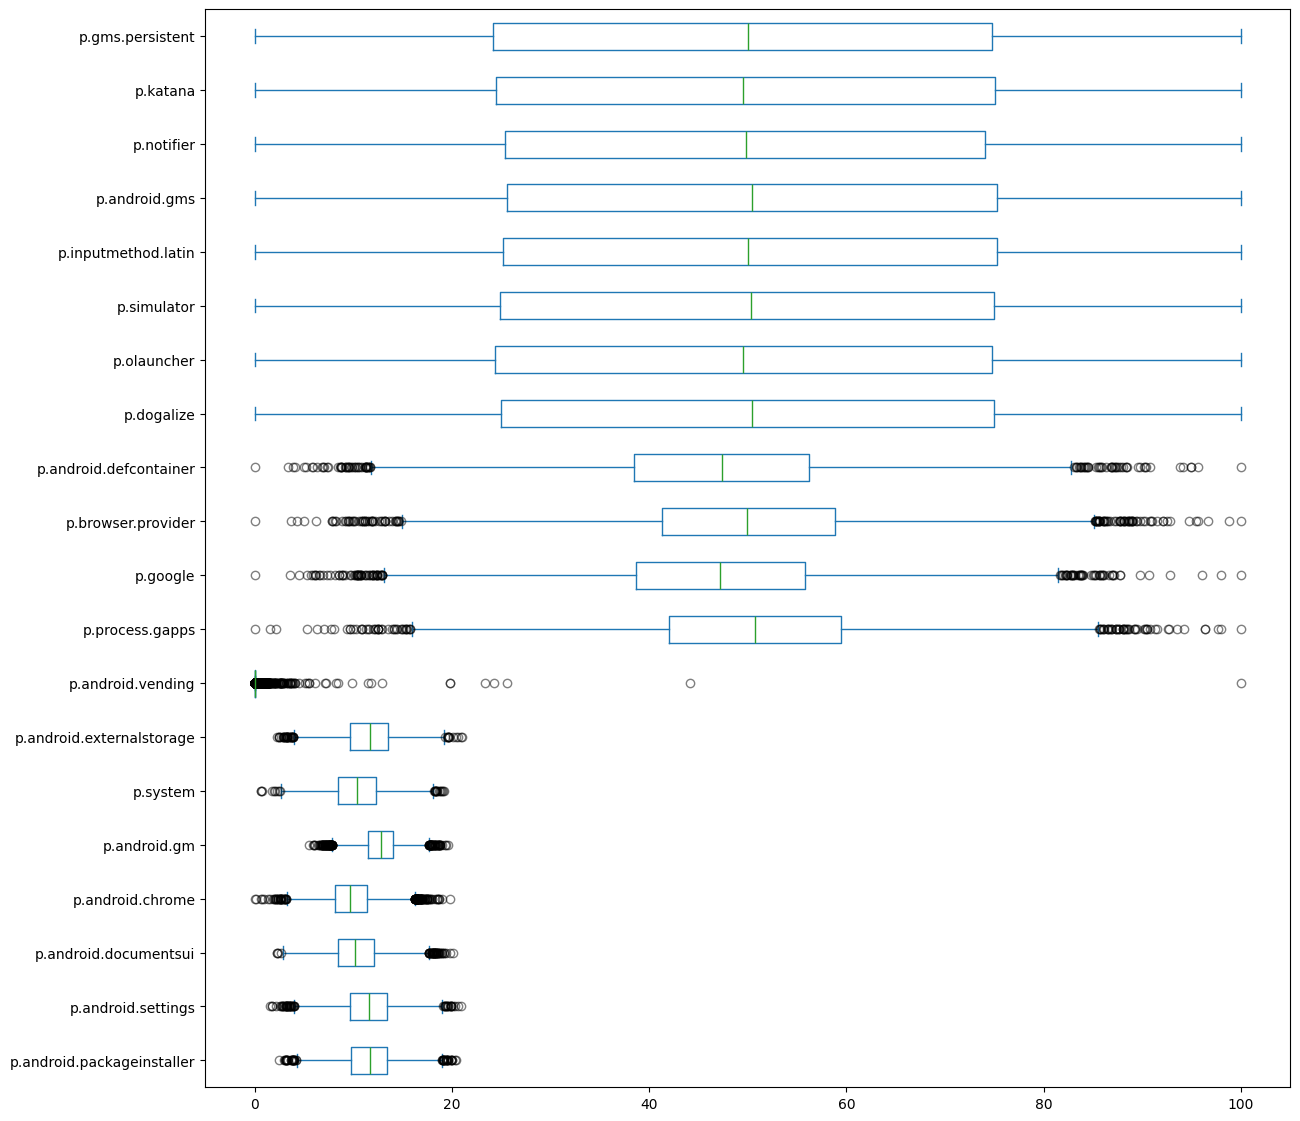

In [61]:
dataset["processes"].iloc[:, 3:].plot(
    kind="box", vert=False, figsize=(14, 14), flierprops=dict(marker="o", color="r", alpha=0.5)
)

#### Outlier detections using **Z-score**


Number of outliers in **Connections**


In [62]:
z_scores = dataset["connections"].iloc[:, 2:].apply(stats.zscore)
outliers = z_scores[(z_scores.abs() > 3).any(axis=1)]
print(f"Number of connections with |z-score| > 3: {len(outliers)}")

Number of connections with |z-score| > 3: 229


Number of outliers in **Processes**


In [63]:
z_scores = dataset["processes"].iloc[:, 2:].apply(stats.zscore)
outliers = z_scores[(z_scores.abs() > 3).any(axis=1)]
print(f"Number of processes with |z-score| > 3: {len(outliers)}")

Number of processes with |z-score| > 3: 411


Removing outliers from **Connections** and showing boxplot


In [64]:
connections_copy = dataset["connections"].copy()
print("Number of connections before removing outliers:\t", connections_copy.shape[0])

connections_copy = connections_copy[(np.abs(stats.zscore(connections_copy.iloc[:, 2:])) < 3).all(axis=1)]
print("Number of connections after removing outliers:\t", connections_copy.shape[0])

Number of connections before removing outliers:	 15108
Number of connections after removing outliers:	 14879


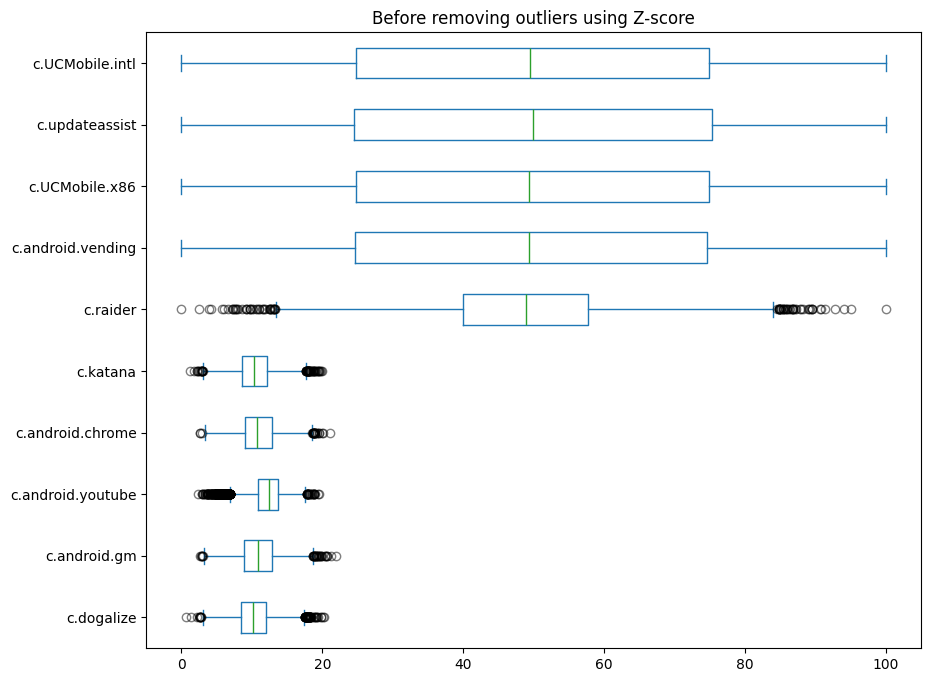

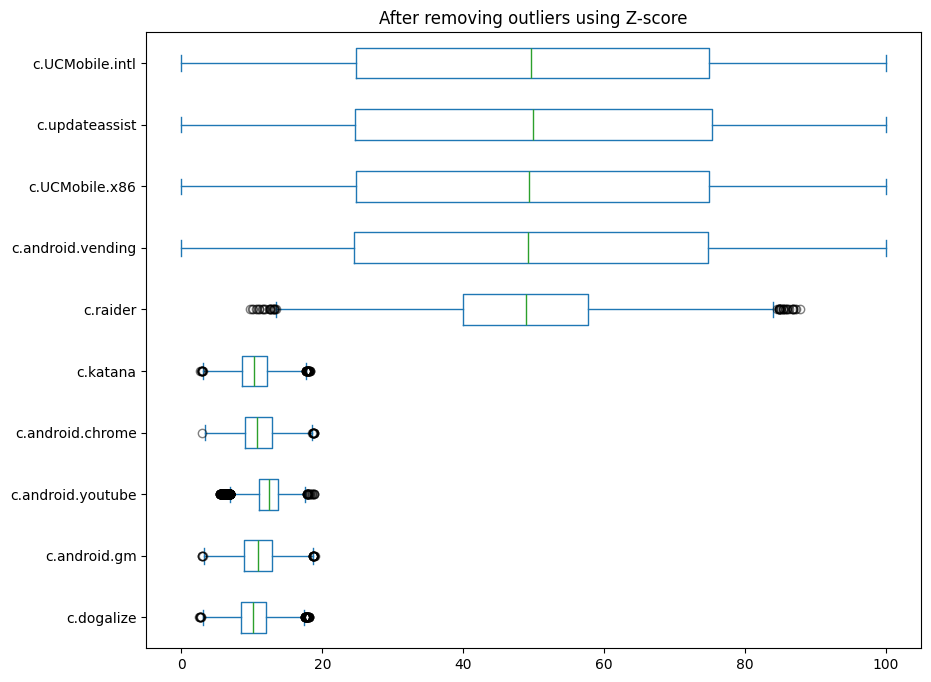

In [65]:
dataset["connections"].iloc[:, 3:].plot(
    kind="box", vert=False, figsize=(10, 8), flierprops=dict(marker="o", color="r", alpha=0.5)
)
plt.title("Before removing outliers using Z-score")
plt.show()

connections_copy.iloc[:, 3:].plot(
    kind="box", vert=False, figsize=(10, 8), flierprops=dict(marker="o", color="r", alpha=0.5)
)
plt.title("After removing outliers using Z-score")
plt.show()

#### Outlier detections using **IQR**


In [66]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)

    return a[(a > upper) | (a < lower)]

In [67]:
connections_copy = dataset["connections"].copy()
print("Number of connections before removing outliers:\t", connections_copy.shape[0])

outlier = connections_copy.iloc[:, 2:].apply(identify_outliers)
connections_copy = connections_copy.drop(outlier.index)
print("Number of connections after removing outliers:\t", connections_copy.shape[0])

Number of connections before removing outliers:	 15108
Number of connections after removing outliers:	 14449


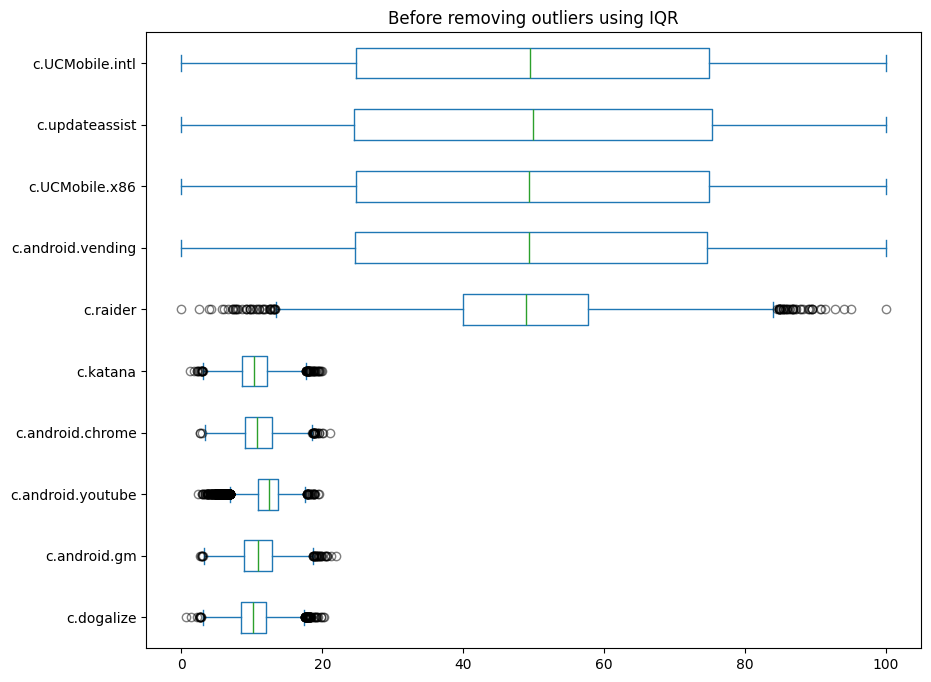

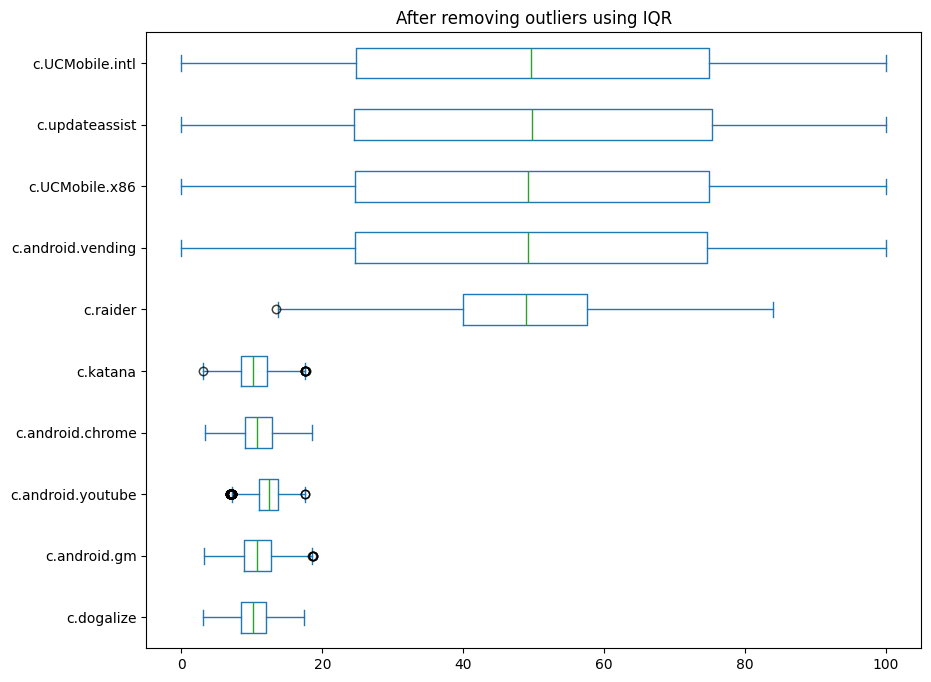

In [68]:
dataset["connections"].iloc[:, 3:].plot(
    kind="box", vert=False, figsize=(10, 8), flierprops=dict(marker="o", color="r", alpha=0.5)
)
plt.title("Before removing outliers using IQR")
plt.show()

connections_copy.iloc[:, 3:].plot(
    kind="box", vert=False, figsize=(10, 8), flierprops=dict(marker="o", color="r", alpha=0.5)
)
plt.title("After removing outliers using IQR")
plt.show()

In [69]:
# z_scores = dataset["connections"].iloc[:, 2:].apply(stats.zscore)

# # Vytvorenie masky pre hodnoty, kde je Z-skóre väčšie než 3 alebo menšie než -3
# outlier_mask = z_scores.abs() > 3

# # Použitie masky na nastavenie hodnôt na NaN len v stĺpcoch s outliers
# dataset["connections"].iloc[:, 2:] = dataset["connections"].iloc[:, 2:].mask(outlier_mask, np.nan)

# dataset["connections"]

# 1.3 Formulation and statistical verification of hypotheses about data


## A.)


### c.android.youtube


$H_0$: c.android.youtube has same values for mwra = 0 and mwra = 1

$H_A$: c.android.youtube has different values (higher) for mwra = 0 and mwra = 1


In [70]:
connections_copy = dataset["connections"].copy()

In [71]:
without_mwra = connections_copy[connections_copy["mwra"] == 0][["c.android.youtube", "mwra"]].dropna()
outlier = without_mwra.apply(identify_outliers)
without_mwra = without_mwra.drop(outlier.index)
without_mwra.drop(columns="mwra", inplace=True)
without_mwra.reset_index(drop=True, inplace=True)
without_mwra.head()

c.android.youtube
0           12.24554
1           14.42927
2           11.10147
3            9.95046
4           10.87766

In [72]:
with_mwra = connections_copy[connections_copy["mwra"] == 1][["c.android.youtube", "mwra"]].dropna()
outlier = with_mwra.apply(identify_outliers)
with_mwra = with_mwra.drop(outlier.index)
with_mwra.drop(columns="mwra", inplace=True)
with_mwra.reset_index(drop=True, inplace=True)
with_mwra.head()

c.android.youtube
0           15.07671
1           13.20187
2           10.77881
3           12.75057
4           14.46671

In [73]:
anderson_result = stats.anderson(with_mwra["c.android.youtube"], dist="norm")
print(anderson_result)
print(f"\nDoes fit normal distribution: {anderson_result.fit_result.success}")

AndersonResult(statistic=np.float64(1.0870665216825728), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(12.744017265021458), scale=np.float64(1.5713846154327715))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Does fit normal distribution: True


In [74]:
anderson_result = stats.anderson(without_mwra["c.android.youtube"], dist="norm")
print(anderson_result)
print(f"\nDoes fit normal distribution: {anderson_result.fit_result.success}")

AndersonResult(statistic=np.float64(8.313498576339043), critical_values=array([0.576, 0.656, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(11.209492566465793), scale=np.float64(2.626717266279064))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Does fit normal distribution: True


In [75]:
stats.levene(with_mwra["c.android.youtube"], without_mwra["c.android.youtube"])

LeveneResult(statistic=np.float64(1880.2645411214794), pvalue=np.float64(0.0))

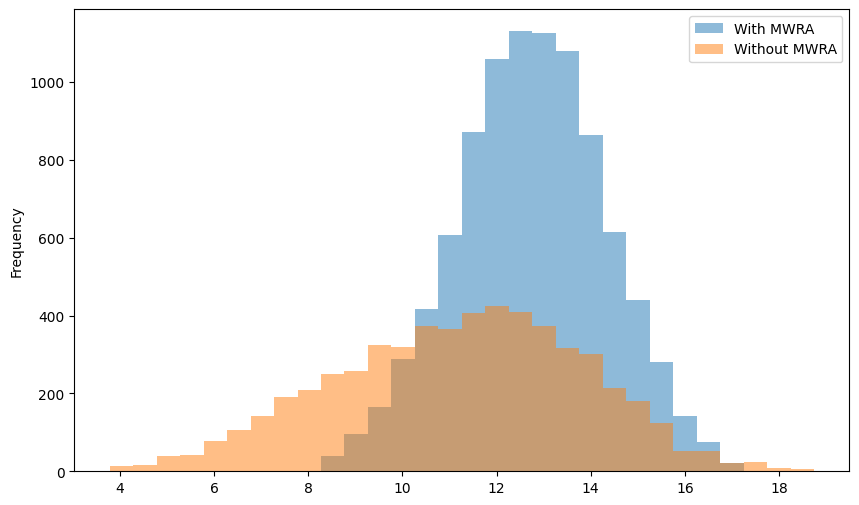

In [76]:
data_to_plot = pd.DataFrame(
    {"With MWRA": with_mwra["c.android.youtube"], "Without MWRA": without_mwra["c.android.youtube"]}
).plot(kind="hist", bins=30, alpha=0.5, figsize=(10, 6))

In [77]:
stat, p_value = stats.ttest_ind(
    with_mwra["c.android.youtube"], without_mwra["c.android.youtube"], equal_var=False
)

print(f"Welch’s T-test Statistic: {stat}")
print(f"p_value: {float(p_value):.10f}")

if p_value < 0.05:
    print(
        "There is a significant difference between the c.android.youtube with malware-related-activity and without."
    )
else:
    print("No significant difference between the two groups.")

if stat < 0:
    print("c.android.youtube has higher weight in normal activity")
else:
    print("c.android.youtube has higher weight in malware-related activity")

Welch’s T-test Statistic: 39.782726909967266
p_value: 0.0000000000
There is a significant difference between the c.android.youtube with malware-related-activity and without.
c.android.youtube has higher weight in malware-related activity


In [78]:
power_analysis = TTestIndPower()

mean_with_mwra = with_mwra["c.android.youtube"].mean()
mean_without_mwra = without_mwra["c.android.youtube"].mean()
std_with_mwra = with_mwra["c.android.youtube"].std()
std_without_mwra = without_mwra["c.android.youtube"].std()

pooled_std = ((std_with_mwra**2 + std_without_mwra**2) / 2) ** 0.5
effect_size = (mean_with_mwra - mean_without_mwra) / pooled_std

alpha = 0.05
sample_size = len(with_mwra) + len(without_mwra)

power = power_analysis.power(
    effect_size=effect_size, nobs1=len(with_mwra), alpha=alpha, ratio=len(without_mwra) / len(with_mwra)
)

if power > 0.8:
    print(f"Yes, the strength of the test is sufficient. Power: {power:.2f}")
else:
    print(f"No, the strength of the test is not sufficient. Power: {power:.2f}")

Yes, the strength of the test is sufficient. Power: 1.00


In [79]:
required_sample_size = power_analysis.solve_power(
    effect_size=effect_size, alpha=alpha, power=0.8, ratio=len(without_mwra) / len(with_mwra)
)
print(f"required data size for the strength of 0.8 is: {required_sample_size:.0f}")
print(
    "actual size data of with_mwra: ",
    len(with_mwra),
    " actual size data of without_mwra: ",
    len(without_mwra),
)
if len(with_mwra) < required_sample_size or len(without_mwra) < required_sample_size:
    print("We need to collect more data")
else:
    print("We have enough data")

required data size for the strength of 0.8 is: 43
actual size data of with_mwra:  9320  actual size data of without_mwra:  5642
We have enough data


### p.android.settings


$H_0$: p.android.setting has same values for mwra = 0 and mwra = 1

$H_A$: p.android.setting has different (higher) values for mwra = 0 and mwra = 1


In [80]:
with_mwra = dataset["processes"][(dataset["processes"]["mwra"] == 1)][["mwra", "p.android.settings"]]
without_mwra = dataset["processes"][(dataset["processes"]["mwra"] == 0)][["mwra", "p.android.settings"]]

print("Number of with_mwra before removing outliers:\t", with_mwra.shape[0])
print("Number of without_mwra before removing outliers:\t", without_mwra.shape[0])

outliers = with_mwra.apply(identify_outliers)
with_mwra = with_mwra.drop(outliers.index)

outliers = without_mwra.apply(identify_outliers)
without_mwra = without_mwra.drop(outliers.index)

print("Number of with_mwra after removing outliers:\t", with_mwra.shape[0])
print("Number of without_mwra after removing outliers:\t", without_mwra.shape[0])

Number of with_mwra before removing outliers:	 9451
Number of without_mwra before removing outliers:	 5657
Number of with_mwra after removing outliers:	 9362
Number of without_mwra after removing outliers:	 5581


In [81]:
anderson_result = stats.anderson(with_mwra["p.android.settings"], dist="norm")
print(anderson_result)
print(f"\nDoes fit normal distribution: {anderson_result.fit_result.success}")

AndersonResult(statistic=np.float64(1.5900194245259627), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(12.637440684682762), scale=np.float64(2.0802485096391754))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Does fit normal distribution: True


In [82]:
anderson_result = stats.anderson(without_mwra["p.android.settings"], dist="norm")
print(anderson_result)
print(f"\nDoes fit normal distribution: {anderson_result.fit_result.success}")

AndersonResult(statistic=np.float64(4.041368508479536), critical_values=array([0.576, 0.656, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(9.589476509586095), scale=np.float64(2.2675502351028958))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Does fit normal distribution: True


In [83]:
stats.levene(with_mwra["p.android.settings"], without_mwra["p.android.settings"])

LeveneResult(statistic=np.float64(39.54468947621198), pvalue=np.float64(3.295531947734141e-10))

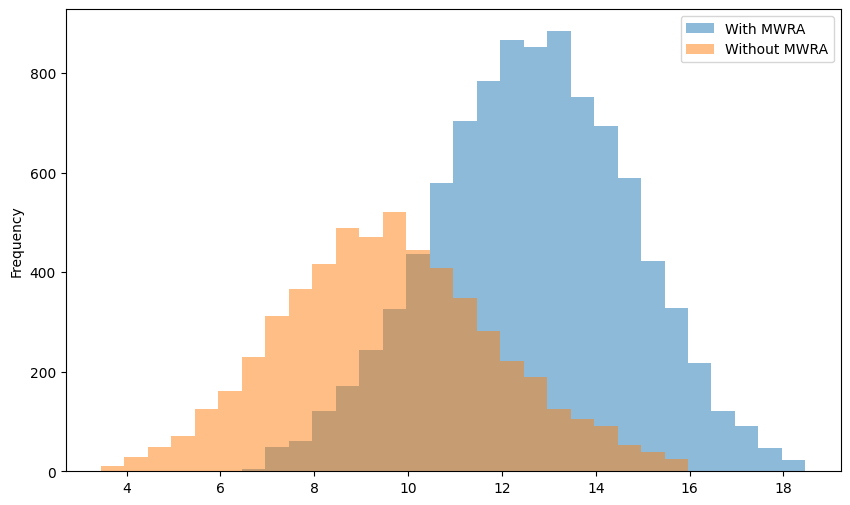

In [84]:
data_to_plot = pd.DataFrame(
    {"With MWRA": with_mwra["p.android.settings"], "Without MWRA": without_mwra["p.android.settings"]}
).plot(kind="hist", bins=30, alpha=0.5, figsize=(10, 6))

In [85]:
stat, p_value = stats.ttest_ind(
    with_mwra["p.android.settings"], without_mwra["p.android.settings"], equal_var=False
)

print(f"Welch’s T-test Statistic: {stat}")
print(p_value)

if p_value < 0.05:
    print(
        "There is a significant difference between the p.android.settings with malware-related-activity and without."
    )
else:
    print("No significant difference between the two groups.")

if stat < 0:
    print("p.android.settings has higher weight in normal activity")
else:
    print("p.android.settings has higher weight in malware-related activity")

Welch’s T-test Statistic: 81.94353732411071
0.0
There is a significant difference between the p.android.settings with malware-related-activity and without.
p.android.settings has higher weight in malware-related activity


TODO: zisit ci sa tabulky v connecitona processes mwra rovanju v case


In [86]:
power_analysis = TTestIndPower()

mean_with_mwra = with_mwra["p.android.settings"].mean()
mean_without_mwra = without_mwra["p.android.settings"].mean()
std_with_mwra = with_mwra["p.android.settings"].std()
std_without_mwra = without_mwra["p.android.settings"].std()

pooled_std = ((std_with_mwra**2 + std_without_mwra**2) / 2) ** 0.5
effect_size = (mean_with_mwra - mean_without_mwra) / pooled_std

alpha = 0.05
sample_size = len(with_mwra) + len(without_mwra)

power = power_analysis.power(
    effect_size=effect_size, nobs1=len(with_mwra), alpha=alpha, ratio=len(without_mwra) / len(with_mwra)
)

if power > 0.8:
    print(f"Yes, the strength of the test is sufficient. Power: {power:.2f}")
else:
    print(f"No, the strength of the test is not sufficient. Power: {power:.2f}")

Yes, the strength of the test is sufficient. Power: 1.00


In [87]:
required_sample_size = power_analysis.solve_power(
    effect_size=effect_size, alpha=alpha, power=0.8, ratio=len(without_mwra) / len(with_mwra)
)
print(f"required data size for the strength of 0.8 is: {required_sample_size:.0f}")
print(
    "actual size data of with_mwra: ",
    len(with_mwra),
    " actual size data of without_mwra: ",
    len(without_mwra),
)
if len(with_mwra) < required_sample_size or len(without_mwra) < required_sample_size:
    print("We need to collect more data")
else:
    print("We have enough data")

required data size for the strength of 0.8 is: 12
actual size data of with_mwra:  9362  actual size data of without_mwra:  5581
We have enough data


# Nothing Important


In [88]:
import sys


def format_size(size):
    """Convert size in bytes to KB or MB as appropriate."""
    if size >= 1024 * 1024:
        return f"{size / (1024 * 1024):.2f} MB"
    elif size >= 1024:
        return f"{size / 1024:.2f} KB"
    else:
        return f"{size} bytes"


def print_memory_usage():

    memory_usage_list = []

    for name, var in globals().items():
        try:
            memory_usage_list.append((name, sys.getsizeof(var)))
        except TypeError:
            memory_usage_list.append((name, float("inf")))  # Use infinity for undetermined sizes

    # Sort the list by memory usage in descending order
    memory_usage_list.sort(key=lambda x: x[1], reverse=True)

    # Print the sorted list
    print("Memory usage of variables (sorted):")
    print(f"Memory sum: {format_size(sum(size for _, size in memory_usage_list))}")
    for name, size in memory_usage_list:
        if size == float("inf"):
            print(f"Memory usage of {name}: Unable to determine size")
        else:
            print(f"Memory usage of {name}: {format_size(size)}")


print_memory_usage()

Memory usage of variables (sorted):
Memory sum: 17.58 MB
Memory usage of df: 3.52 MB
Memory usage of combined_df: 2.42 MB
Memory usage of z_scores: 2.42 MB
Memory usage of profiles_copy: 1.60 MB
Memory usage of _59: 1.60 MB
Memory usage of connections_copy: 1.50 MB
Memory usage of _4: 1003.43 KB
Memory usage of with_mwra: 477.49 KB
Memory usage of without_mwra: 259.88 KB
Memory usage of times: 236.22 KB
Memory usage of _9: 236.22 KB
Memory usage of _7: 236.09 KB
Memory usage of value_counts: 233.06 KB
Memory usage of chrome_data: 118.19 KB
Memory usage of dogalize_data: 118.19 KB
Memory usage of gm_data: 118.19 KB
Memory usage of youtube_data: 118.19 KB
Memory usage of katana_data: 118.19 KB
Memory usage of raider_data: 118.19 KB
Memory usage of vending_data: 118.19 KB
Memory usage of x86_data: 118.19 KB
Memory usage of updateassist_data: 118.19 KB
Memory usage of intl_data: 118.19 KB
Memory usage of settings_data: 118.19 KB
Memory usage of system_data: 118.19 KB
Memory usage of simula